# Pypi network evolution

##### Setup olivia

In [1]:
# Olivia Finder requirements
%pip install -r ../olivia/requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os
from time import time
import networkx as nx
import psutil
from collections import Counter

# Append the path to the olivia_finder package
import sys
sys.path.append('../../olivia/')

from olivia.model import OliviaNetwork


Set up variables

In [3]:
REPO_NAME = "PyPI"
OUT_IMG_DIR = f"../img/{REPO_NAME}"

# Create output directory
if not os.path.exists(OUT_IMG_DIR):
    os.makedirs(OUT_IMG_DIR)



#### **Utilities**

In [4]:

def add_chunk(
    df, G, dependent_field, dependency_field,
    filter_field=None,
    filter_value=None
):
    """ Utility method for build_dependency_network"""
    filtered = df[df[filter_field] == filter_value] if filter_field else df
    links = list(zip(filtered[dependency_field], filtered[dependent_field]))
    G.add_edges_from(links)
    return G

def build_dependency_network(
    df,
    chunk_size,
    dependent_field: str = 'Project Name',
    dependency_field: str = 'Dependency Name',
    filter_field=None,
    filter_value=None,
    verbose: bool = True
):
    # Print only if verbose
    vprint = print if verbose else lambda *a, **k: None
    process = psutil.Process(os.getpid())
    vprint("Using process ", process)
    t = time()
    try:
        vprint('Initializing graph... ', end='')
        # New NetworkX directed Graph
        G = nx.DiGraph()
        vprint('OK')
        
        # Split DataFrame into chunks
        chunks = [df[i:i + chunk_size] for i in range(0, len(df), chunk_size)]
        
        for i, chunk in enumerate(chunks):
            # Add dependencies from chunk to G
            add_chunk(
                chunk, 
                G,
                dependent_field=dependent_field,
                dependency_field=dependency_field,
                filter_field=filter_field,
                filter_value=filter_value
            )
            vprint(f'{round(i*chunk_size/1e6,1)}M lines | {len(G)} nodes, {len(G.edges)} deps. ({int(time()-t)}s) {round(process.memory_info().rss/1e6,1)}Mb')
        vprint('Done processing DataFrame')
        
        return G
    
    except Exception as e:
        print('\n', e)

def plot_degree_distribution(G, title, color, save=False, filename=None):
    '''
    Plot the degree distribution of a networkx graph
    '''

    # Nodes' degree vector
    degree=[x[1] for x in G.degree()]
    
    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Set title
    fig.suptitle(title, fontsize=20, fontweight='bold')
    
    # Plot linear histogram
    # Order nodes' degree vector
    sorted_degree = sorted(degree, reverse=True)
    axs[0].plot(sorted_degree, color=color)
    axs[0].set_xlabel('Nodes')
    axs[0].set_ylabel('Degree')
    axs[0].set_yscale('log')
    
    
    # Plot histogram with log scale
    axs[1].hist(degree, bins=100, color=color)
    axs[1].set_xlabel('Degree')
    axs[1].set_ylabel('Number of nodes')
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')

    # Save figure
    if save:
        plt.savefig(filename, bbox_inches='tight')
    
    plt.show()

def draw_networkx_graph(G, layout='circular', size=(20,20)):
    '''
    Draw a networkx graph
    '''

    layouts = {
        'circular': nx.circular_layout,
        'kamada_kawai': nx.kamada_kawai_layout,
        'random': nx.random_layout,
        'shell': nx.shell_layout,
        'spring': nx.spring_layout,
        'spectral': nx.spectral_layout,
        'random': nx.random_layout,
    }
    plt.figure(figsize=size)
    pos = layouts[layout](G)
    node_size = [G.in_degree(node) * 80 for node in G]
    node_color = [G.in_degree(node) for node in G]
    edge_color = 'black'
    width = 1
    nx.draw_networkx(G, pos=pos, node_size=node_size, node_color=node_color, alpha=0.7,
                     with_labels=False, edge_color=edge_color, width=width)
    
    # Agregar etiquetas personalizadas
    labels = {node: node for node in G.nodes()}
    node_labels = nx.draw_networkx_labels(G, pos=pos, labels=labels, font_size=8,
                                          font_weight='bold', bbox=dict(facecolor='red', edgecolor='none', pad=0.3))

    plt.gca().set_aspect('equal')
    plt.axis('off')
    plt.show()


def draw_package_deep_network(G, package_name, deep, size=(10, 10), layout='spring', title=None):
    '''
    Draw the subgraph of a package and its dependencies up to a certain depth.

    '''

    layouts = {
        'circular': nx.circular_layout,
        'kamada_kawai': nx.kamada_kawai_layout,
        'random': nx.random_layout,
        'shell': nx.shell_layout,
        'spring': nx.spring_layout,
        'spectral': nx.spectral_layout,
    }

    # Create a subgraph of the package and its dependencies up to a certain depth
    # subgraph = nx.ego_graph(G, package_name, radius=deep, center=True)
    subgraph = nx.ego_graph(G, package_name, radius=deep, center=True)

    # Draw the subgraph
    plt.figure(figsize=size)
    pos = layouts[layout](subgraph)
    node_size = [subgraph.in_degree(node) * 100 for node in subgraph]
    node_color = [subgraph.in_degree(node) for node in subgraph]
    edge_color = 'black'
    width = 1
    nx.draw_networkx(subgraph, pos=pos, node_size=node_size, node_color=node_color, alpha=0.7,
                        with_labels=False, edge_color=edge_color, width=width)
    
    # Add title
    if title:
        plt.title(title, fontsize=16, fontweight='bold')


    # Set target node square in blue
    nx.draw_networkx_nodes(subgraph, pos=pos, nodelist=[package_name], node_size=100, node_color='blue', alpha=0.7)

    # Add custom labels
    labels = {node: node for node in subgraph.nodes()}
    nx.draw_networkx_labels(
        subgraph, pos=pos, labels=labels, font_size=8,
        font_weight='bold', bbox=dict(facecolor='red', edgecolor='none', pad=0.3)
    )
    
    plt.gca().set_aspect('equal')
    plt.axis('off')
    plt.show()

    return subgraph

# def plot_comparation(m1, m2, t_m1, t_m2, offset=0):
#     plt.figure(figsize=(15, 3))
    
#     # Gráfico para libraries.io
#     plt.subplot(1, 2, 1)
#     plt.bar([x[0] for x in m1], [x[1] for x in m1], color='orange')
#     plt.xticks(rotation=90)
#     plt.title(t_m1, fontsize=14, fontweight='bold')
#     plt.ylabel(t_m1)
#     plt.grid(axis='y', linestyle='--', alpha=0.7)
#     plt.gca().spines['top'].set_visible(False)
#     plt.gca().spines['right'].set_visible(False)
#     plt.gca().tick_params(axis='x', labelsize=12)
#     plt.gca().tick_params(axis='y', labelsize=12)
#     bar_size = [x[1] for x in m1]
#     for i in range(len(m1)):
#         plt.text(i, bar_size[i] + offset , str(bar_size[i]), ha='center', va='center', color='black')

#     # Gráfico para Scraped Packages
#     plt.subplot(1, 2, 2)
#     plt.bar([x[0] for x in m2], [x[1] for x in m2], color='purple')
#     plt.xticks(rotation=90)
#     plt.title(t_m2, fontsize=14, fontweight='bold')
#     plt.ylabel(t_m2)
#     plt.grid(axis='y', linestyle='--', alpha=0.7)
#     plt.gca().spines['top'].set_visible(False)
#     plt.gca().spines['right'].set_visible(False)
#     plt.gca().tick_params(axis='x', labelsize=12)
#     plt.gca().tick_params(axis='y', labelsize=12)
#     bar_size = [x[1] for x in m2]
#     for i in range(len(m2)):
#         plt.text(i, bar_size[i] + offset, str(bar_size[i]), ha='center', va='center', color='white')

#     plt.show()

def plot_comparison(
        ss, tt_G, save=False, filename=None, 
        xticks_rotation=0, bar_offset=0, xticks_size=16, 
        font_size=14, rotation=90, tittle=None, metric=None, comparable=None):
    
    tt = []
    for node in ss:
        if node[0] in tt_G.nodes():
            tt.append((node[0], comparable[node[0]]))
        else:
            tt.append((node[0], 0))

    # Plot comparison
    plt.figure(figsize=(15, 3))

    colors = ['orange', 'purple']

    plt.bar(
        [x[0] for x in tt],
        [x[1] for x in tt],
        label='Scraped',
        color=colors[1],
        width=0.4,
        alpha=1,
        hatch='..'
    )

    plt.bar(
        [x[0] for x in ss],
        [x[1] for x in ss],
        label='Libraries.io',
        color=colors[0],
        width=0.6,
        alpha=0.6
    )

    for i, v, i2, v2 in zip([x[0] for x in tt], [x[1] for x in tt], [x[0] for x in ss], [x[1] for x in ss]):
        plt.text(i, max(v, v2) + bar_offset, f'{v} - {v2}', color='black', ha='center', rotation=rotation, fontsize=font_size)


    # Adjusting plot borders
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Adjusting tick labels font size
    plt.gca().tick_params(axis='x', labelsize=xticks_size)
    plt.gca().tick_params(axis='y', labelsize=xticks_size)

    plt.title(tittle, fontsize=20, fontweight='bold', pad=50)
    plt.xlabel('Package name')
    plt.ylabel(metric)
    plt.xticks(rotation=xticks_rotation)
    plt.legend()

    if save:
        plt.savefig(filename, bbox_inches='tight')

    plt.show()


def plot_comparison_reversed(
        ss, tt_G, save=False, filename=None, 
        xticks_rotation=0, bar_offset=0, xticks_size=16, 
        font_size=14, rotation=90, tittle=None, metric=None, comparable=None):
    
    tt = []
    for node in ss:
        if node[0] in tt_G.nodes():
            tt.append((node[0], comparable[node[0]]))
        else:
            tt.append((node[0], 0))

    # Plot comparison
    plt.figure(figsize=(15, 3))

    colors = ['orange', 'purple']

    plt.bar(
        [x[0] for x in ss],
        [x[1] for x in ss],
        label='Scraped',
        color=colors[1],
        width=0.4,
        alpha=1,
        hatch='..'
    )

    plt.bar(
        [x[0] for x in tt],
        [x[1] for x in tt],
        label='Libraries.io',
        color=colors[0],
        width=0.6,
        alpha=0.6
    )

    for i, v, i2, v2 in zip([x[0] for x in tt], [x[1] for x in tt], [x[0] for x in ss], [x[1] for x in ss]):
        plt.text(i, max(v, v2) + bar_offset, f'{v} - {v2}', color='black', ha='center', rotation=rotation, fontsize=font_size)


    # Adjusting plot borders
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Adjusting tick labels font size
    plt.gca().tick_params(axis='x', labelsize=xticks_size)
    plt.gca().tick_params(axis='y', labelsize=xticks_size)

    plt.title(tittle, fontsize=20, fontweight='bold', pad=50)
    plt.xlabel('Package name')
    plt.ylabel(metric)
    plt.xticks(rotation=xticks_rotation)
    plt.legend()

    if save:
        plt.savefig(filename, bbox_inches='tight')

    plt.show()

def plot_bar_chart(m1, m2, tit, offset = 1000):
    # Configuring colors
    colors = ['orange', 'purple']

    # Heights of the bars
    height_libio = [node[1] for node in m1]
    height_scraped = [node[1] for node in m2]

    # Create the bar plot (one bar next to each other)
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(np.arange(len(m1)), height_libio, color=colors[0], width=0.4)
    ax.bar(np.arange(len(m2)) + 0.4, height_scraped, color=colors[1], width=0.4)

    # Configure xticks orientation and position
    ax.set_xticks(np.arange(len(m1)) + 0.2)
    ax.set_xticklabels([node[0] for node in m1], rotation=45, ha='right', fontsize=8)

    # Configure titles and axis labels
    ax.set_title(tit, fontsize=20, fontweight='bold')
    ax.set_xlabel('Package')
    ax.set_ylabel('In degree')

    # Add labels to the sections of the bar chart
    for i, v in enumerate(height_libio):
        ax.text(i, v + offset, str(v), ha='center', va='center', color='black', rotation=90)
    for i, v in enumerate(height_scraped):
        ax.text(i + 0.4, v + offset, str(v), ha='center', va='center', color='black', rotation=90)

    # Add a horizontal grid
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Adjusting plot borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Adjusting tick labels font size
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

    # Configure legend
    legend_labels = ['librariesio', 'scraped']
    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
    ax.legend(legend_handles, legend_labels)

    # Show the bar plot
    plt.show()

def calculate_metrics(G):
    '''
    Calculates the following metrics for a given graph:
    - Number of nodes
    - Number of edges
    - Average clustering coefficient
    - Average shortest path length
    - Number of connected components
    - Diameter
    - Average degree
    - Average in degree
    - Average out degree
    - Number of self-loops
    - Number of isolated nodes
    '''
    
    return pd.DataFrame(
        {
            'Number of nodes': [G.number_of_nodes()],
            'Number of edges': [G.number_of_edges()],
            'Average clustering coefficient': [nx.average_clustering(G)],
            'Average degree': [sum(dict(G.degree()).values())/G.number_of_nodes()],
            'Average in degree': [sum(dict(G.in_degree()).values())/G.number_of_nodes()],
            'Average out degree': [sum(dict(G.out_degree()).values())/G.number_of_nodes()],
            'Number of isolated nodes': [len(list(nx.isolates(G)))]
        }
    )

def plot_dict(d, title, xlabel, ylabel, rotation=90, size=None, offset=100, label_size=12, label_rotation=0, font_size=14, color='orange', tit_pad=20, w=0.4, save=False, filename=None):
    '''
    Plots a dictionary as a bar chart.
    '''

    plt.figure(figsize=size)
    plt.bar(d.keys(), d.values(), color=color, width=w)
    # add text size
    plt.xticks(rotation=label_rotation, fontsize=label_size)
    plt.title(title, fontsize=20, fontweight='bold', pad=tit_pad)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().tick_params(axis='x', labelsize=label_size)
    plt.gca().tick_params(axis='y', labelsize=label_size)
    bar_size = [x[1] for x in d.items()]
    for i in range(len(d)):
        plt.text(i, bar_size[i] + offset, str(bar_size[i]), ha='center', va='center', color='black', rotation=rotation, size=font_size)

    # Save plot
    if save:
        plt.savefig(filename, bbox_inches='tight')  # Use bbox_inches='tight' to prevent cropping

    plt.show()


def plot_data(data, metric, title, color):
    data.sort(reverse=True)
    plt.figure(figsize=(10, 5))
    x, y = zip(*Counter(data).items())
    plt.plot(x, y, color=color, alpha=0.6, marker='.', linestyle='None', markersize=10, label='package')

    plt.title(title, fontsize=20, fontweight='bold', pad=20)
    plt.xlabel(metric)
    plt.ylabel('Frequency')
    plt.xscale('log')
    plt.yscale('log')
    # grid
    plt.grid(axis='y', alpha=0.5)
    plt.grid(axis='x', alpha=0.5)

    # Adjusting plot borders
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Adjusting tick labels font size
    plt.gca().tick_params(axis='x', labelsize=14)
    plt.gca().tick_params(axis='y', labelsize=14)
    plt.legend()
    plt.show()


## 1 - Data processing

### Librariesio network data analysis

**1 - Visualization of librariesio DataSet**

In [5]:
# # Load librariesio csv file
# librariesio_df = pd.read_csv('../results/csv_datasets/pypi/pypi_adjlist_librariesio.csv')

# # Remove not necessary columns
# librariesio_df = librariesio_df.drop(
#     columns=[
#         'ID', 
#         'Platform', 
#         'Project ID', 
#         'Version ID', 
#         'Dependency Platform', 
#         'Optional Dependency', 
#         'Dependency Requirements', 
#         'Dependency Project ID'
#     ]
# )

# # Saw number of rows and columns
# initial_rows = librariesio_df.shape[0]
# print("Dataframe shape: ", librariesio_df.shape)
# librariesio_df.head(10)

**2 - Collection of versions for the same package**

One of the things we notice is that there are data entries for different versions of the same package. Let's show an example.

In [6]:
# # Sow nmfem package
# librariesio_df[librariesio_df['Project Name'] == '1pass']

To solve this issue, we will only consider the most recent version of the package.

Let's observe the format that these version numbers take:

In [7]:
# # Show librariesio_df dataframe unique values at column 'Version Number'
# print("Unique values at column 'Version Number': ", librariesio_df['Version Number'].unique())
# print("Total:",len(librariesio_df['Version Number'].unique()))

Assuming that the dataset is sorted with packages in ascending order of version, we generate a package-version dictionary that associates each package with the latest updated version.

In [8]:
# package_version = {}

# # Loop all the rows
# for index, row in tqdm.tqdm(librariesio_df.iterrows(), total=librariesio_df.shape[0]):
#     # Get the version number
#     version_number = row['Version Number']
#     # Get the project name
#     project_name = row['Project Name']

#     if project_name not in package_version:
#         package_version[project_name] = version_number
#     else:
#         if version_number != package_version[project_name]:
#             package_version[project_name] = version_number


In [9]:
# # Show the dictionary
# package_version["1pass"]

In [10]:
# # Identify the rows to keep
# mask = librariesio_df['Version Number'] == librariesio_df['Project Name'].map(package_version)

# # Filter the dataframe
# librariesio_df = librariesio_df[mask]

The result is a filtered dataset, removing package duplicity for different version numbers.

In [11]:
# # Sow nmfem package
# librariesio_df[librariesio_df['Project Name'] == '1pass']

In total, the data processing yields the following statistics:

In [12]:
# final_rows = librariesio_df.shape[0]

# print("Initial rows: ", initial_rows)
# print("Final rows: ", final_rows)
# print("Rows removed: ", initial_rows - final_rows)

**3 - Librariesio "Dependency Kind" field**

As you can see, the libraries.io dataset includes a lot of irrelevant information. That's why we're going to clean it up to get a better visualization of the data.

One of the first things we notice is the "Dependency Kind" field. This field indicates the type of dependency that a particular package is. This classification is specific to the R programming language.

There are different types:


In [13]:
# # Obtener los distintos tipos de "Dependency Kind"
# librariesio_df['Dependency Kind'].unique().tolist()

In [14]:
# # Export the dataframe to csv
# librariesio_df.to_csv('../results/csv_datasets/pypi/pypi_adjlist_librariesio_filtered.csv', index=False)

In [15]:
# librariesio_df.head()

In [16]:
# Read the csv file
librariesio_df = pd.read_csv('../results/csv_datasets/pypi/pypi_adjlist_librariesio_filtered.csv')

### Scraped network data analysis

**1 - Visualization of scraped dataset**

In [17]:
scraped_df = pd.read_csv('../results/csv_datasets/pypi/pypi_adjlist_scraping.csv')
# Remove colunmn version
scraped_df = scraped_df.drop(columns=['version', 'url', 'dependency_version', 'dependency_url'])
print(scraped_df.shape)
scraped_df.head()


(933955, 2)


name dependency
0  0x-sra-client    urllib3
1  0x-sra-client        six
2  0x-sra-client    certifi
3  0x-sra-client     python
4  0x-sra-client         0x

As can be observed, this dataset contains 197460 distinct packages.

In [18]:
# Number of rows with unique name values
print("Unique values at column 'name': ", len(scraped_df['name'].unique()))

Unique values at column 'name':  197460


## 2 - Comparation

### **Packages evolution**

By comparing the packages present in the different generated networks, we conclude that CRAN has been growing during this period of time (approximately 16%), and one-third of the existing packages have been replaced by others.

In [19]:
libraiesio_packages = librariesio_df['Project Name'].unique().tolist()
scraping_packages = scraped_df['name'].unique().tolist()
common_packages = list(set(libraiesio_packages) & set(scraping_packages))

print ("Packages in librariesio: ", len(libraiesio_packages))
print ("Packages in scraped: ", len(scraping_packages))
print ("Common packages: ", len(common_packages))
print("Packages in librariesio that are not in scraped: ", len(list(set(libraiesio_packages) - set(scraping_packages))))
print("Packages in scraped that are not in librariesio: ", len(list(set(scraping_packages) - set(libraiesio_packages))))

Packages in librariesio:  41621
Packages in scraped:  197460
Common packages:  24001
Packages in librariesio that are not in scraped:  17620
Packages in scraped that are not in librariesio:  173459


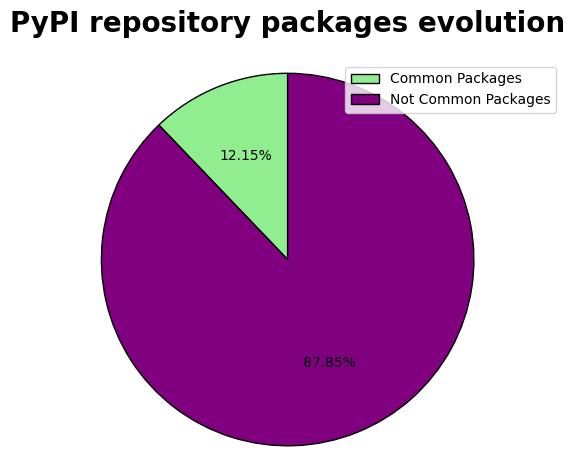

In [20]:
# Data for the graph
labels = ['Common Packages', 'Not Common Packages']
colors = ['lightgreen', 'purple']
sizes = [len(common_packages), len(list(set(scraping_packages) - set(libraiesio_packages)))]

# Customize the graph
fig, ax = plt.subplots()
ax.pie(sizes, autopct='%1.2f%%', startangle=90, colors=colors)
ax.set_aspect('equal')
ax.set_title(f'{REPO_NAME} repository packages evolution', fontsize=20, fontweight='bold', pad=20)

# add a black border to the pie

for pie_wedge in ax.patches:
    pie_wedge.set_edgecolor('black')

# Add legend
ax.legend(labels, loc='best')

# Improve aesthetics
plt.axis('equal')
plt.tight_layout()

# Display the graph
plt.show()

# Save the graph
fig.savefig(f'{OUT_IMG_DIR}/circ_common_packages.png')

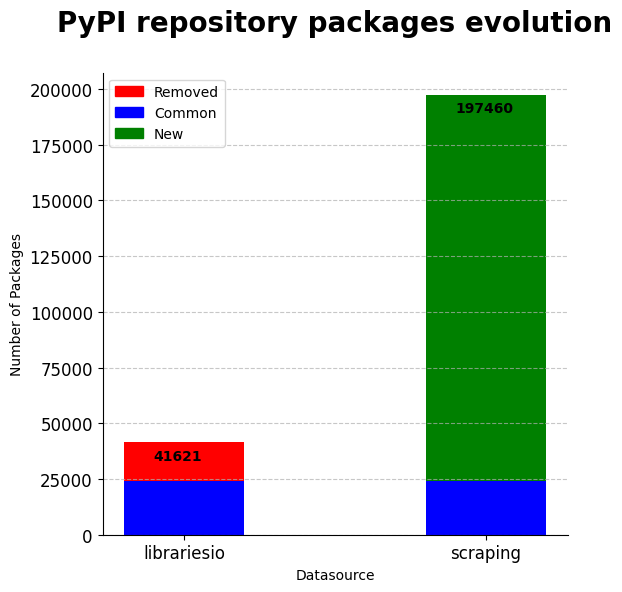

In [21]:
# Identifying common packages, exclusive to lista1, and exclusive to lista2
common_packages = list(set(libraiesio_packages) & set(scraping_packages))
new_packages = list(set(scraping_packages) - set(libraiesio_packages))
old_packages = list(set(libraiesio_packages) - set(scraping_packages))

# Configuring colors
colors_lista1 = ['red', 'blue']
colors_lista2 = ['green', 'blue']

# Heights of the bars
height_lista1 = len(libraiesio_packages)
height_lista2 = len(scraping_packages)

# Create the bar plot
fig, ax = plt.subplots(figsize=(6, 6))

# Bar for lista1
ax.bar('librariesio', height_lista1, color=colors_lista1, width=0.4)
ax.bar('librariesio', len(old_packages), color='red', width=0.4,)
ax.bar('librariesio', len(common_packages), color='blue', width=0.4)

# Bar for lista2
ax.bar('scraping', height_lista2, color=colors_lista2, width=0.4)
ax.bar('scraping', len(new_packages), color='green', width=0.4)
ax.bar('scraping', len(common_packages), color='blue', width=0.4)

# Configure titles and axis labels
ax.set_title(f'{REPO_NAME} repository packages evolution', fontsize=20, fontweight='bold', pad=30)
ax.set_xlabel('Datasource')
ax.set_ylabel('Number of Packages')

# Add labels to the sections of the bar chart
ax.text(-0.1, height_lista1 - 8000, str(height_lista1), color='black', fontweight='bold')
ax.text(0.9, height_lista2 - 8000, str(height_lista2), color='black', fontweight='bold')

# Add a horizontal grid
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjusting plot borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjusting tick labels font size
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Configure legend
legend_labels = ['Removed', 'Common', 'New']
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors_lista1 + ['green']]
ax.legend(legend_handles, legend_labels)

# Show the bar plot
plt.show()

# Save the bar plot
fig.savefig(f'{OUT_IMG_DIR}/bar_common_packages.png')


### **Network analysis**

We construct the networks to perform the analysis, using a directed network (A --> B, where B is a direct dependency of A).

In [22]:
# Libraries.io graph
librariesio_G = build_dependency_network(
    df = librariesio_df,
    chunk_size = 100000,
    dependent_field = 'Project Name',
    dependency_field = 'Dependency Name',
)

# Scraped graph
scraped_G = build_dependency_network(
    df = scraped_df,
    chunk_size = 100000,
    dependent_field = 'name',
    dependency_field = 'dependency',
)

Using process  psutil.Process(pid=100092, name='python', status='running', started='13:33:24')
Initializing graph... OK
0.0M lines | 36460 nodes, 99878 deps. (0s) 246.4Mb
0.1M lines | 49306 nodes, 134575 deps. (0s) 265.6Mb
Done processing DataFrame
Using process  psutil.Process(pid=100092, name='python', status='running', started='13:33:24')
Initializing graph... OK
0.0M lines | 27862 nodes, 100000 deps. (0s) 319.5Mb
0.1M lines | 50691 nodes, 200000 deps. (0s) 369.8Mb
0.2M lines | 74430 nodes, 300000 deps. (0s) 417.2Mb
0.3M lines | 95992 nodes, 400000 deps. (1s) 471.6Mb
0.4M lines | 116076 nodes, 500000 deps. (1s) 515.6Mb
0.5M lines | 146334 nodes, 600000 deps. (1s) 568.0Mb
0.6M lines | 168073 nodes, 700000 deps. (2s) 614.3Mb
0.7M lines | 187955 nodes, 800000 deps. (2s) 676.0Mb
0.8M lines | 207589 nodes, 900000 deps. (2s) 719.7Mb
0.9M lines | 214470 nodes, 933955 deps. (2s) 730.2Mb
Done processing DataFrame


In [23]:
# Libraries.io model
librariesio_model = OliviaNetwork()
librariesio_model.build_model(librariesio_G)

# Scraped based model
scraped_model = OliviaNetwork()
scraped_model.build_model(scraped_G)

Building Olivia Model
     Finding strongly connected components (SCCs)...
     Building condensation network...
     Adding structural meta-data...
     Done
Building Olivia Model
     Finding strongly connected components (SCCs)...
     Building condensation network...


#### **1 - Degree**

Regarding the degree distribution, no significant changes are observed.

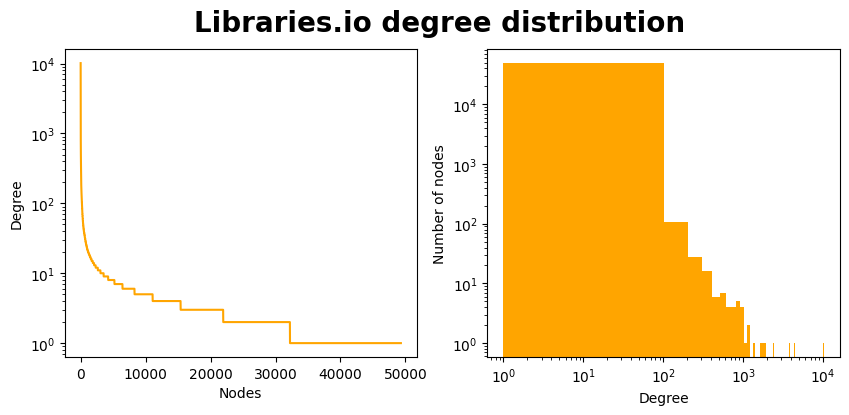

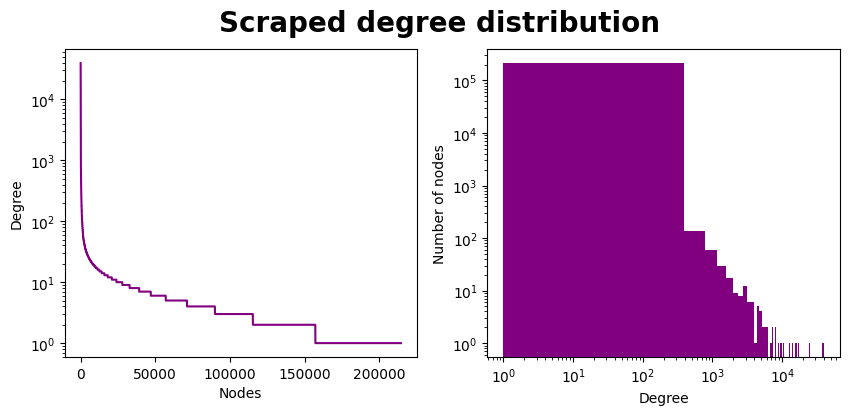

In [ ]:
plot_degree_distribution(librariesio_G, 'Libraries.io degree distribution', "orange", save=True, filename=f'{OUT_IMG_DIR}/librariesio_degree_distribution.png')
plot_degree_distribution(scraped_G, 'Scraped degree distribution', "purple", save=True, filename=f'{OUT_IMG_DIR}/scraped_degree_distribution.png')

It can indeed be observed that there has been an increase in the average degree of the network during this evolution.

In [ ]:
# Libraries.io graph average degree
print("Average degree of libraries.io graph: ", librariesio_G.number_of_edges() / librariesio_G.number_of_nodes())
# Scraped graph average degree
print("Average degree of scraped graph: ", scraped_G.number_of_edges() / scraped_G.number_of_nodes())



Average degree of libraries.io graph:  2.729383847807569
Average degree of scraped graph:  4.354711614678044


#### **2 - Out degree**

##### Evolution

Top out degree librariesio packages evolution

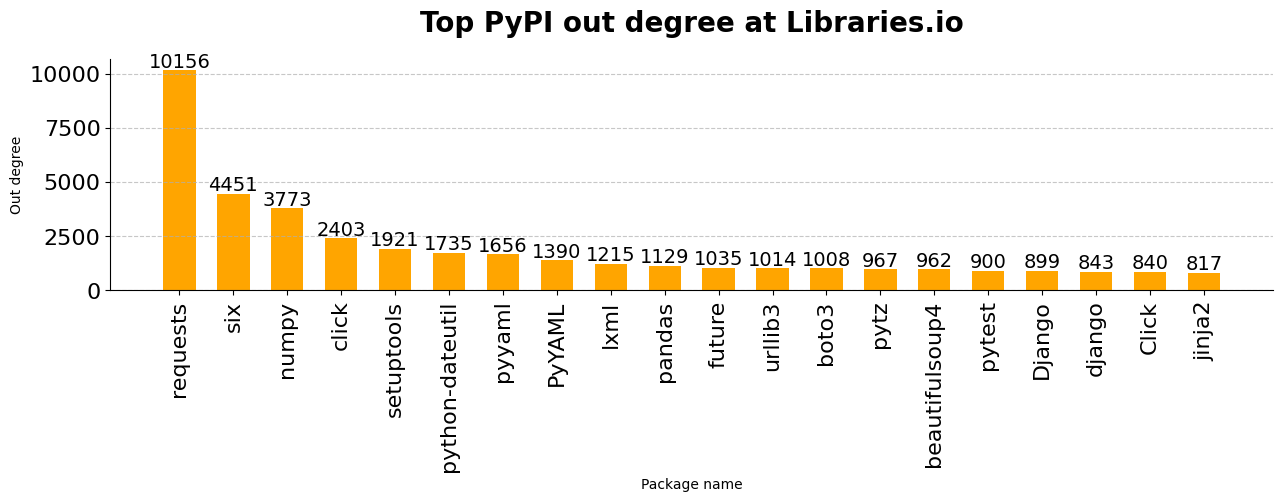

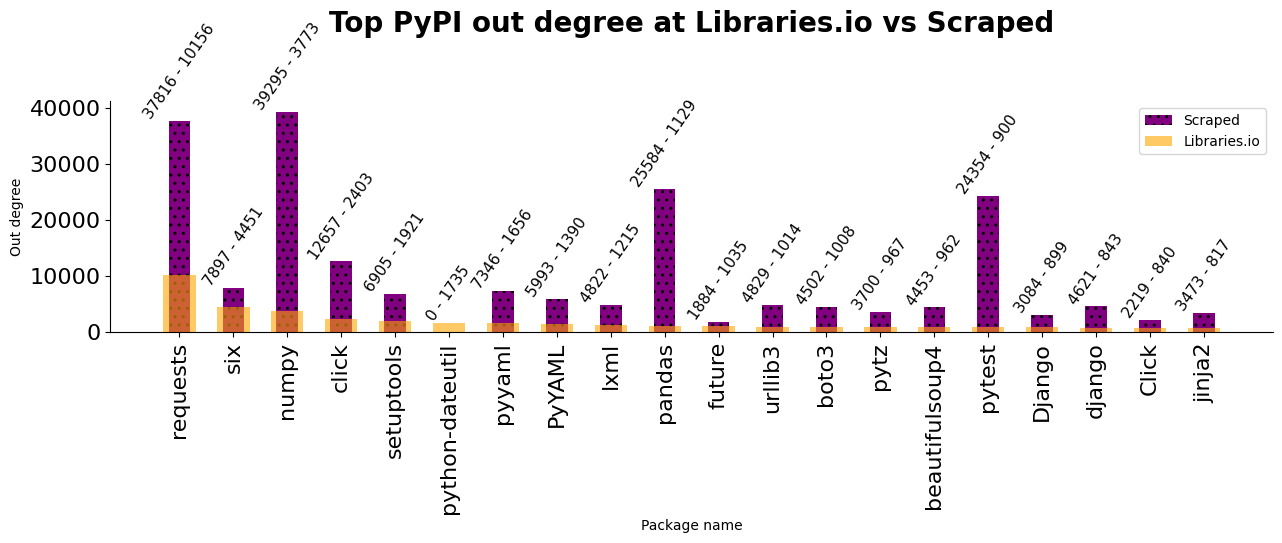

In [ ]:
libio_t20_outd = sorted(librariesio_G.out_degree(), key=lambda x: x[1], reverse=True)[:20]

plot_dict(
    d = dict(libio_t20_outd),
    title = f'Top {REPO_NAME} out degree at Libraries.io',
    xlabel = 'Package name',
    ylabel = 'Out degree',
    rotation = 0,
    size = (15, 3),
    offset = 400,
    label_size = 16,
    font_size = 14,
    label_rotation = 90,
    w=0.6,
    save=True,
    filename=f'{OUT_IMG_DIR}/libio_t20_outd.png',
)


# Plot evolution of top (librariesio) out degree
# ------------------------------------------------
    
plot_comparison(
    ss = libio_t20_outd,
    tt_G = scraped_G,
    save=True,
    filename=f'{OUT_IMG_DIR}/libio_t20_outd_comparison.png',
    xticks_rotation=90,
    bar_offset=400,
    xticks_size=16,
    font_size=11,
    rotation=55,
    tittle=f'Top {REPO_NAME} out degree at Libraries.io vs Scraped',
    metric='Out degree',
    comparable=scraped_G.out_degree(),
)


In [ ]:
# Tabla con la evolucion del componente fuertemente conectado para el top 20 de libio
# -----------------------------------------------------------------------------------

# Top 20 out degree packages at librariesio
libio_t20_outd = sorted(librariesio_G.out_degree(), key=lambda x: x[1], reverse=True)[:20]

# Define a dictionary to store the strongly connected components for each package
libio_t20_outd_scc = {}

# Add the strongly connected components to the dictionary
for package, out_degree in libio_t20_outd:
    libio_t20_outd_scc[package] = [len(librariesio_model[package].scc()), len(scraped_model[package].scc())]

# Create a dataframe with the strongly connected components
t20_outd_scc = pd.DataFrame.from_dict(libio_t20_outd_scc, orient='index', columns=['SCC libraries.io', 'SCC Scraped'])

t20_outd_scc



SCC libraries.io  SCC Scraped
requests                        1          283
six                             1            1
numpy                           1            1
click                           1            1
setuptools                      1          283
python-dateutil                 1            1
pyyaml                          1            1
PyYAML                          1            1
lxml                            1            2
pandas                          1          283
future                          1            1
urllib3                         1          283
boto3                           1          283
pytz                            1            1
beautifulsoup4                  1            1
pytest                          1          283
Django                          1          283
django                          1            1
Click                           1            1
jinja2                          1            1

Top out degree scraped packages evolution

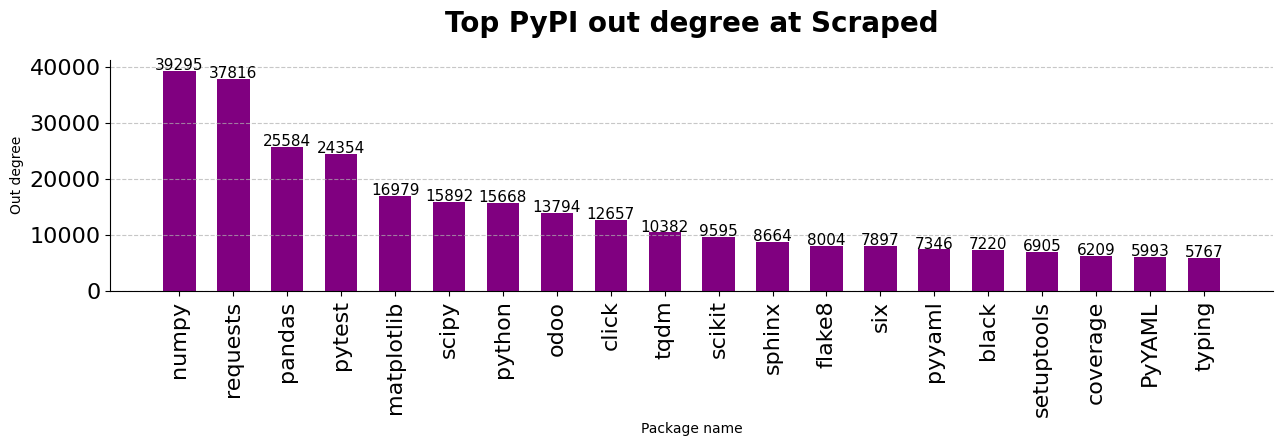

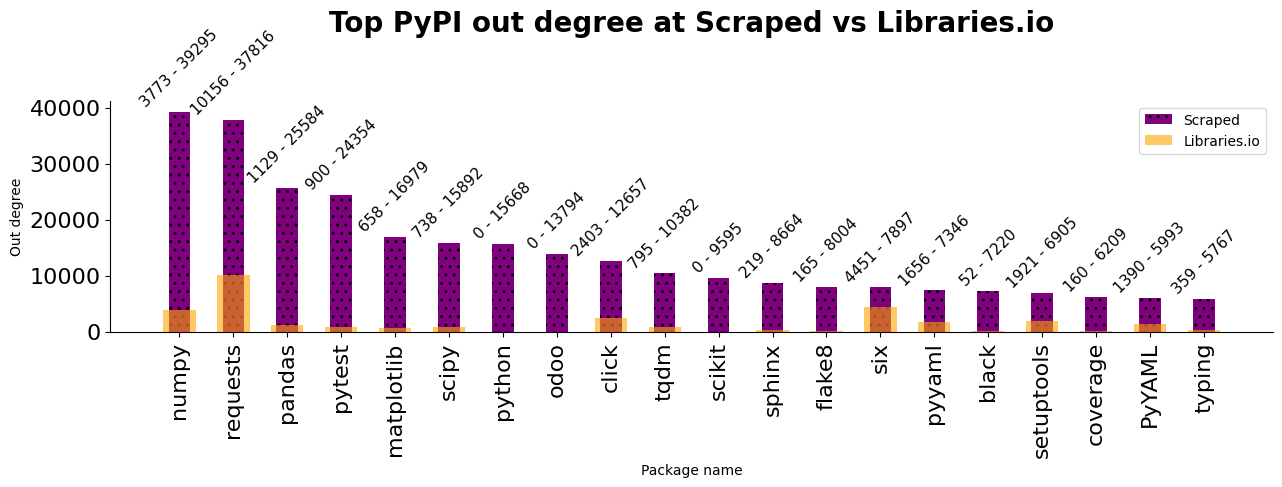

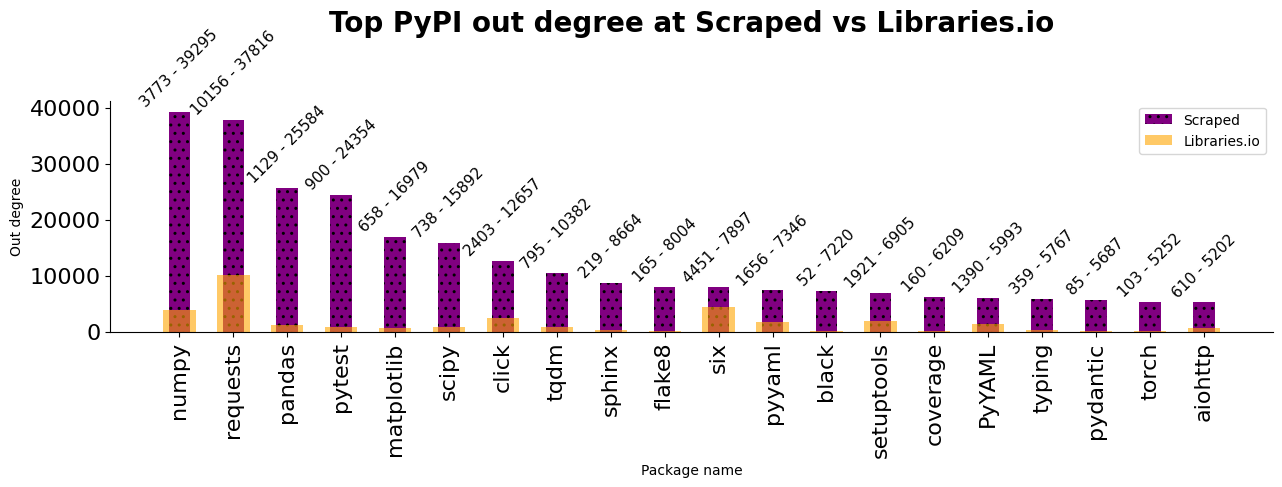

In [ ]:
scraped_t20_outd = sorted(scraped_G.out_degree(), key=lambda x: x[1], reverse=True)[:20]

plot_dict(
    d = dict(scraped_t20_outd),
    title = f'Top {REPO_NAME} out degree at Scraped',
    xlabel = 'Package name',
    ylabel = 'Out degree',
    color='purple',
    rotation = 0,
    size = (15, 3),
    offset = 1000,
    label_size = 16,
    font_size = 11,
    label_rotation = 90,
    w=0.6,
    save=True,
    filename=f'{OUT_IMG_DIR}/scraped_t20_outd.png',
)


# Plot evolution of top (librariesio) out degree
# ------------------------------------------------

plot_comparison_reversed(
    ss = scraped_t20_outd,
    tt_G =librariesio_G,
    save=True,
    filename=f'{OUT_IMG_DIR}/scraped_t20_outd_comparison.png',
    xticks_rotation=90,
    bar_offset=1000,
    xticks_size=16,
    font_size=11,
    rotation=45,
    tittle=f'Top {REPO_NAME} out degree at Scraped vs Libraries.io',
    metric='Out degree',
    comparable=librariesio_G.out_degree(),
)


# Top out degree packages in scraped that are in librariesio
# ---------------------------------------------------------

top_outd_scraped = sorted(scraped_G.out_degree(), key=lambda x: x[1], reverse=True)

top_outd_scraped_in_libio = []
librariesio_nodes = list(librariesio_G.nodes())
for node in top_outd_scraped:
    
    # Check if node is in librariesio
    if node[0] in librariesio_nodes:
        top_outd_scraped_in_libio.append(node)

    if len(top_outd_scraped_in_libio) == 20:
        break


plot_comparison_reversed(
    ss = top_outd_scraped_in_libio,
    tt_G = librariesio_G,
    save=True,
    filename=f'{OUT_IMG_DIR}/libio_scraped_t20_comparation.png',
    xticks_rotation=90,
    bar_offset=1000,
    xticks_size=16,
    font_size=11,
    rotation=45,
    tittle=f'Top {REPO_NAME} out degree at Scraped vs Libraries.io',
    metric='Out degree',
    comparable=librariesio_G.out_degree(),
)


### Scraped SCC

SCC libraries.io  SCC Scraped
numpy                    1.0            1
requests                 1.0          283
pandas                   1.0          283
pytest                   1.0          283
matplotlib               1.0            1
scipy                    1.0          283
python                   NaN            1
odoo                     NaN            1
click                    1.0            1
tqdm                     1.0          283
scikit                   NaN            1
sphinx                   1.0            1
flake8                   1.0            1
six                      1.0            1
pyyaml                   1.0            1
black                    1.0          283
setuptools               1.0          283
coverage                 1.0            1
PyYAML                   1.0            1
typing                   1.0            1

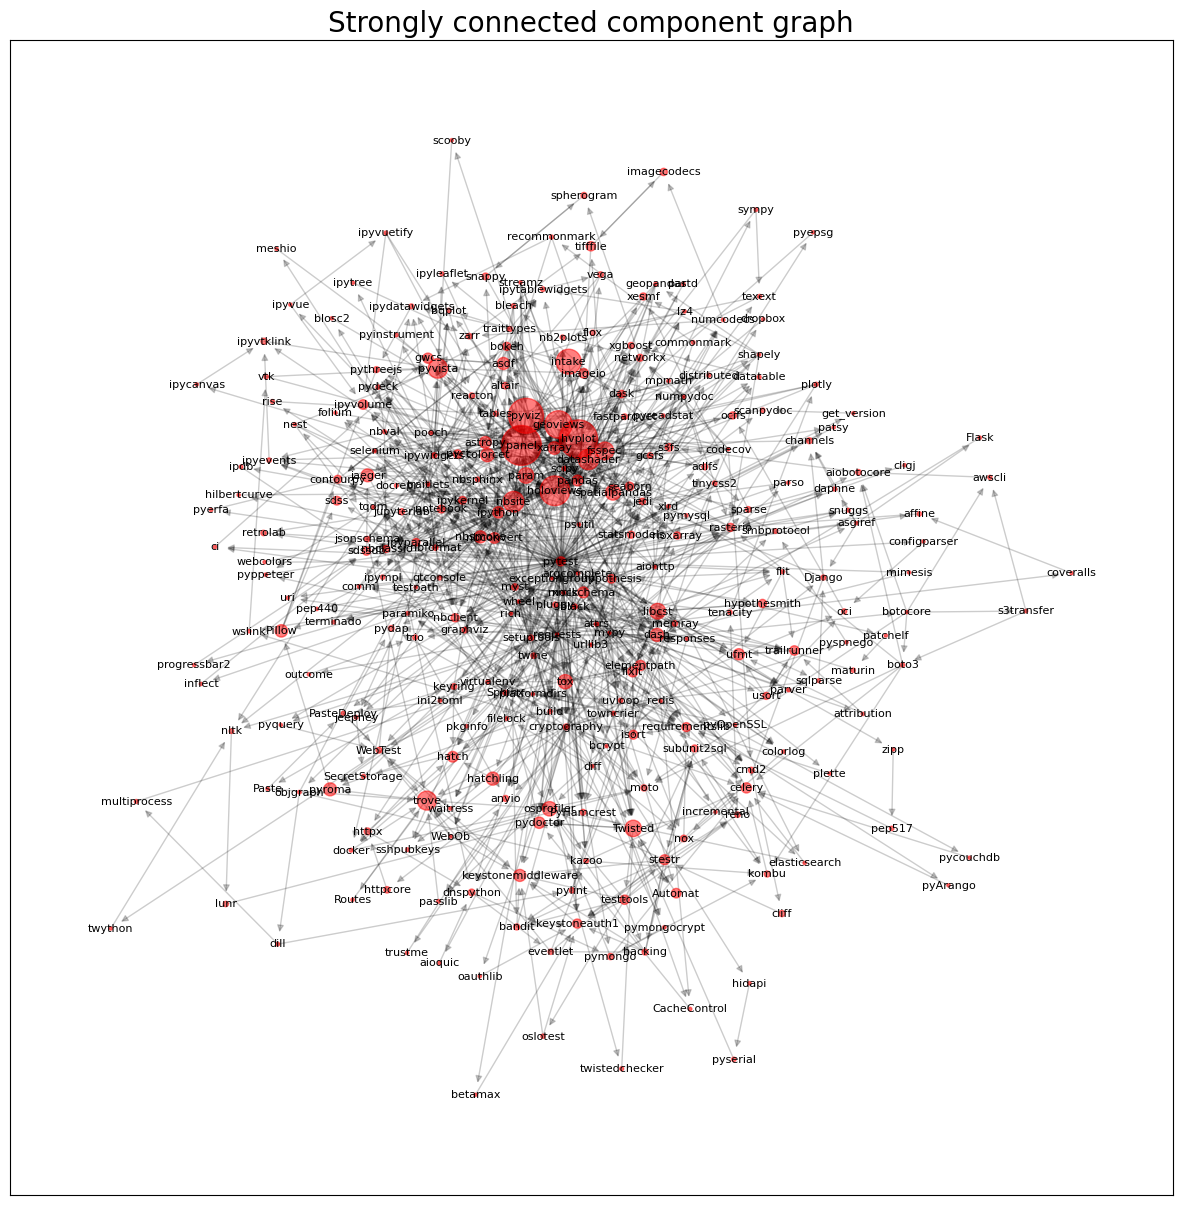

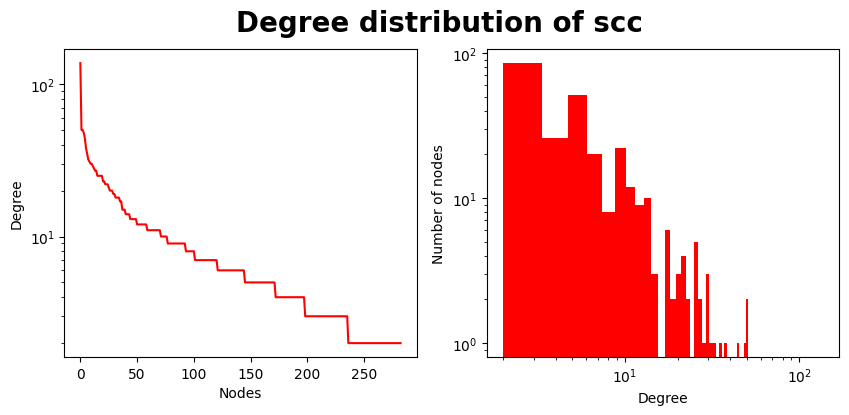

Average degree: 8.890459363957596
Density: 0.015763225822619853
Diameter: 14
Clustering coefficient: 0.1966474283553856


In [ ]:
# Tabla con la evolucion del componente fuertemente conectado para el top 20 de scraped
# -----------------------------------------------------------------------------------

# Top 20 out degree packages at scraped
scraped_t20_outd = sorted(scraped_G.out_degree(), key=lambda x: x[1], reverse=True)[:20]

# Define a dictionary to store the strongly connected components for each package
scraped_t20_outd_scc = {}

# Add the strongly connected components to the dictionary
for package, out_degree in scraped_t20_outd:
    try:
        scraped_t20_outd_scc[package] = [len(librariesio_model[package].scc()), len(scraped_model[package].scc())]
    except:
        scraped_t20_outd_scc[package] = [None, len(scraped_model[package].scc())]

# Create a dataframe with the strongly connected components
t20_outd_scc = pd.DataFrame.from_dict(scraped_t20_outd_scc, orient='index', columns=['SCC libraries.io', 'SCC Scraped'])

display(t20_outd_scc)


# Dibujar el grafo de la componente fuertemente conectada de un paquete
# ---------------------------------------------------------------------

# Plot the strongly connected component
plt.figure(figsize=(15, 15))
plt.title('Strongly connected component graph', fontsize=20)

top_scc  = scraped_model.sorted_clusters()[0]


# Get edges from the strongly connected component
edges = []
for node in top_scc:
    for node2 in top_scc:
        if node != node2:
            if scraped_G.has_edge(node, node2):
                edges.append((node, node2))

# Create the graph
G = nx.DiGraph()
G.add_nodes_from(top_scc)
G.add_edges_from(edges)

# Tamaño de los nodos en funcion del grado de salida
# --------------------------------------------------

# Get the out degree of each node
pr = dict(nx.pagerank(G))

# Get the size of each node
node_size = []
for node in top_scc:
    node_size.append(pr[node] * 10000)




# Draw the graph in circular layout
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='red', alpha=0.5)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.2)
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')


# Distribucion de los grados de los nodos
# ---------------------------------------

# Plot the degree distribution
plot_degree_distribution(
    G = G,
    save=True,
    filename=f'{OUT_IMG_DIR}/degree_distribution_scc.png',
    title=f'Degree distribution of scc',
    color='red'
)

# Grado medio de los nodos
# ------------------------

# Get the average degree
avg_degree = sum([d for n, d in G.degree()]) / len(G.nodes())

print(f'Average degree: {avg_degree}')

# Densidad de la red
# ------------------

# Get the density of the graph
density = nx.density(G)

print(f'Density: {density}')

# Diametro de la red
# ------------------

# Get the diameter of the graph
diameter = nx.diameter(G)

print(f'Diameter: {diameter}')

# Coeficiente de clustering
# -------------------------

# Get the clustering coefficient
clustering_coefficient = nx.average_clustering(G)

print(f'Clustering coefficient: {clustering_coefficient}')



In [ ]:
# Obtener el top20 de componentes fuertemente conectados de scraped
# -----------------------------------------------------------------

# Get the top 20 strongly connected components
top_scc = scraped_model.sorted_clusters()[:20]

# Create a dataframe to store the strongly connected components
top_scc_df = pd.DataFrame(columns=[
    'Size', 
    'Head',
    'Head pagerank',
    'Avg degree',
    'Density', 
    'Diameter', 
    'Clustering coefficient', 
    'Transitive dependencies'
    ]
)

# Crear un grafo con cada componente fuertemente conectado
# --------------------------------------------------------

# Create a graph for each strongly connected component
for i, scc in enumerate(top_scc):
    G = nx.DiGraph()
    
    edges = []
    for node in scc:
        for node2 in scc:
            if node != node2:
                if scraped_G.has_edge(node, node2):
                    edges.append((node, node2))

    nodes = [node for node in scc]

    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    

    # Get the density of the graph
    density = nx.density(G)

    # Get the diameter of the graph
    diameter = nx.diameter(G)

    # Get the clustering coefficient
    clustering_coefficient = nx.average_clustering(G)

    # Get the sum of transitive dependencies for each node
    sum_transitive_dependencies = 0
    for node in scc:
        sum_transitive_dependencies += len(scraped_model[node].transitive_dependencies())

    # Top pagerank of nodes
    pr = dict(nx.pagerank(G.reverse()))
    pr = sorted(pr.items(), key=lambda x: x[1], reverse=True)[0]
    head = pr[0]

    # Get the average degree
    avg_degree = sum([d for n, d in G.degree()]) / len(G.nodes())

    # Add the strongly connected component to the dataframe
    top_scc_df.loc[i] = [
        len(scc),
        head,
        pr[1],
        avg_degree,
        density,
        diameter,
        clustering_coefficient,
        sum_transitive_dependencies
    ]

# Mostrar el top20 de componentes fuertemente conectados de scraped
# -----------------------------------------------------------------

display(top_scc_df)

Size           Head  Head pagerank  Avg degree   Density Diameter  \
0   283         pytest       0.135569    8.890459  0.015763       14   
1    19   transformers       0.169269    4.947368  0.137427        8   
2     8           crds       0.221896    3.000000  0.214286        6   
3     8        lamindb       0.337734    5.250000  0.375000        3   
4     8         pycldf       0.329553    4.750000  0.339286        5   
5     6    grimoirelab       0.412447    5.000000  0.500000        2   
6     6         fdutil       0.315617    4.666667  0.466667        3   
7     6      omnitools       0.436878    3.666667  0.366667        3   
8     5          sunpy       0.351692    2.800000  0.350000        4   
9     5  pytablewriter       0.329746    6.000000  0.750000        2   
10    5           hist       0.315050    3.200000  0.400000        4   
11    5     pyontutils       0.318299    3.600000  0.450000        3   
12    4   featuretools       0.429209    3.000000  0.500000        3   
13    4         arnica       0.328053    2.500000  0.416667        3   
14    4       polyaxon       0.409227    3.000000  0.500000        3   
15    4       fastcore       0.371516    3.000000  0.500000        3   
16    4          shiny       0.429209    3.000000  0.500000        3   
17    4       esmerald       0.429209    3.000000  0.500000        3   
18    4        robotpy       0.390652    4.500000  0.750000        2   
19    3           dacy       0.486486    2.666667  0.666667        2   

    Clustering coefficient Transitive dependencies  
0                 0.196647                  206873  
1                 0.358109                   23807  
2                 0.222222                    6288  
3                 0.383651                    6784  
4                 0.498340                    6752  
5                 0.776190                    4536  
6                 0.470224                    4452  
7                 0.448958                    4440  
8                 0.000000                    3770  
9                 0.777778                    3855  
10                0.386667                    3765  
11                0.421795                    3755  
12                0.406250                    5276  
13                0.000000                    3016  
14                0.406250                    3220  
15                0.700000                    2988  
16                0.406250                    3048  
17                0.406250                    3064  
18                0.800000                    2948  
19                0.000000                    3780

In [ ]:
librariesio_model['pytest'].coupling_profile()

{'pluggy': {'pluggy'},
 'importlib-metadata': {'importlib-metadata', 'pluggy'},
 'more-itertools': {'importlib-metadata', 'more-itertools', 'pluggy'},
 'py': {'py'},
 'packaging': {'packaging'},
 'pyparsing': {'packaging'},
 'wcwidth': {'wcwidth'},
 'attrs': {'attrs'},
 'zipp': {'importlib-metadata', 'pluggy'},
 'six': {'importlib-metadata', 'more-itertools', 'packaging', 'pluggy'}}

###### Top out degree scraped packages evolution

##### Global out degree distribution

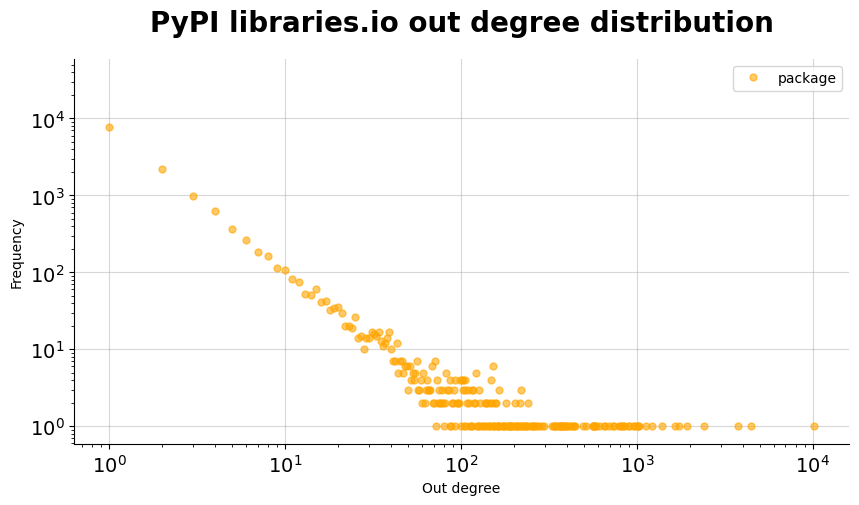

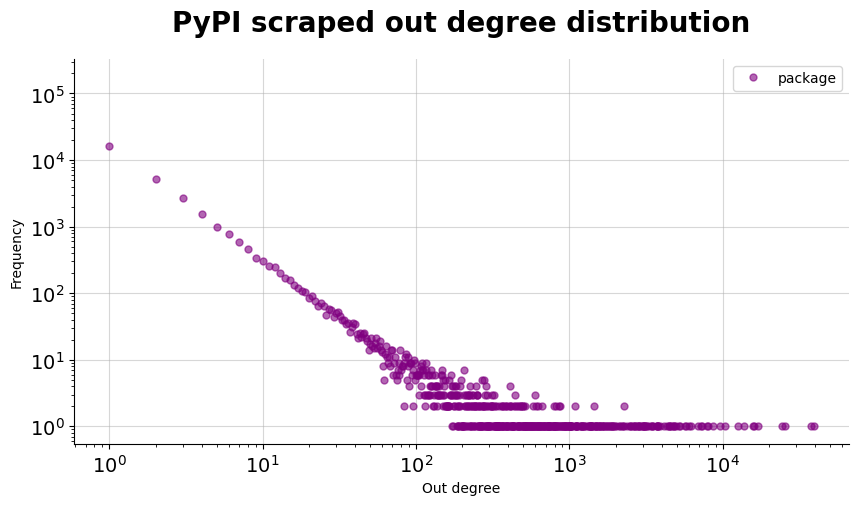

In [ ]:
plot_data(
    data = [x[1] for x in librariesio_G.out_degree()],
    metric='Out degree',
    title=f'{REPO_NAME} libraries.io out degree distribution',
    color="orange"
)

plot_data(
    data = [x[1] for x in scraped_G.out_degree()],
    metric='Out degree',
    title=f'{REPO_NAME} scraped out degree distribution',
    color="purple"
)

#### **3 - In degree**

##### Evolution

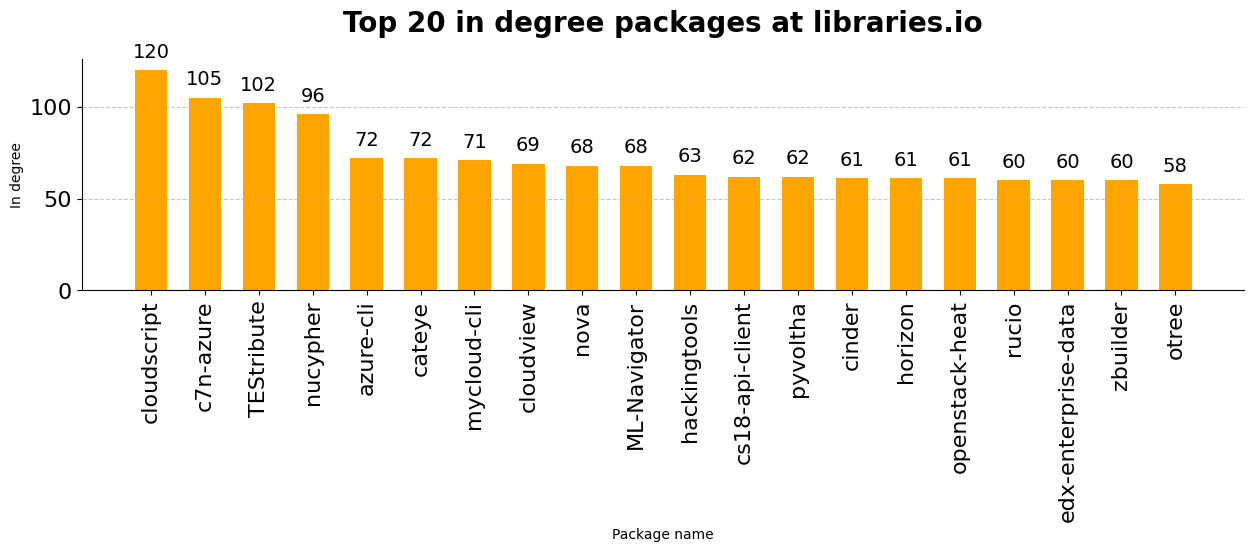

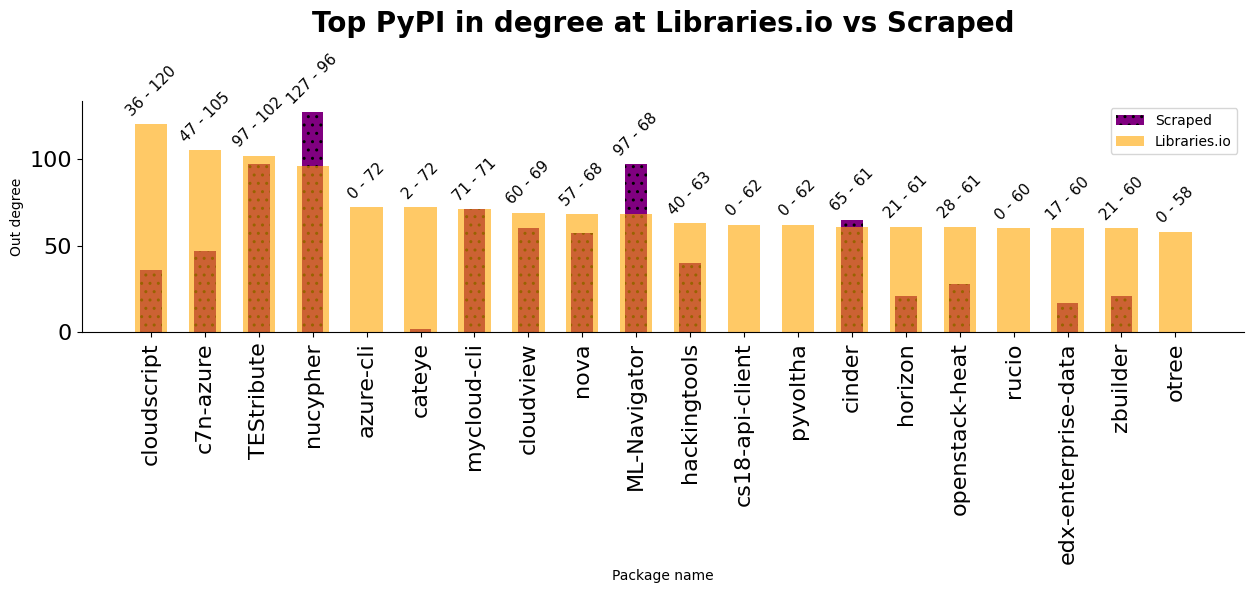

In [ ]:
# Top 10 in degree (libraries.io and scraped input metrics)
# --------------------

libio_t20_ind = sorted(librariesio_G.in_degree(), key=lambda x: x[1], reverse=True)[:20]

plot_dict(
    d = dict(libio_t20_ind),
    title = 'Top 20 in degree packages at libraries.io',
    xlabel = 'Package name',
    ylabel = 'In degree',
    rotation = 0,
    size = (15, 3),
    offset = 10,
    label_size = 16,
    font_size = 14,
    label_rotation = 90,
    w=0.6
)

plot_comparison(
    ss = libio_t20_ind,
    tt_G = scraped_G,
    save=True,
    filename=f'{OUT_IMG_DIR}/libio_t20_ind_comparison.png',
    xticks_rotation=90,
    bar_offset=5,
    xticks_size=16,
    font_size=11,
    rotation=45,
    tittle=f'Top {REPO_NAME} in degree at Libraries.io vs Scraped',
    metric='Out degree',
    comparable=scraped_G.in_degree(),
)


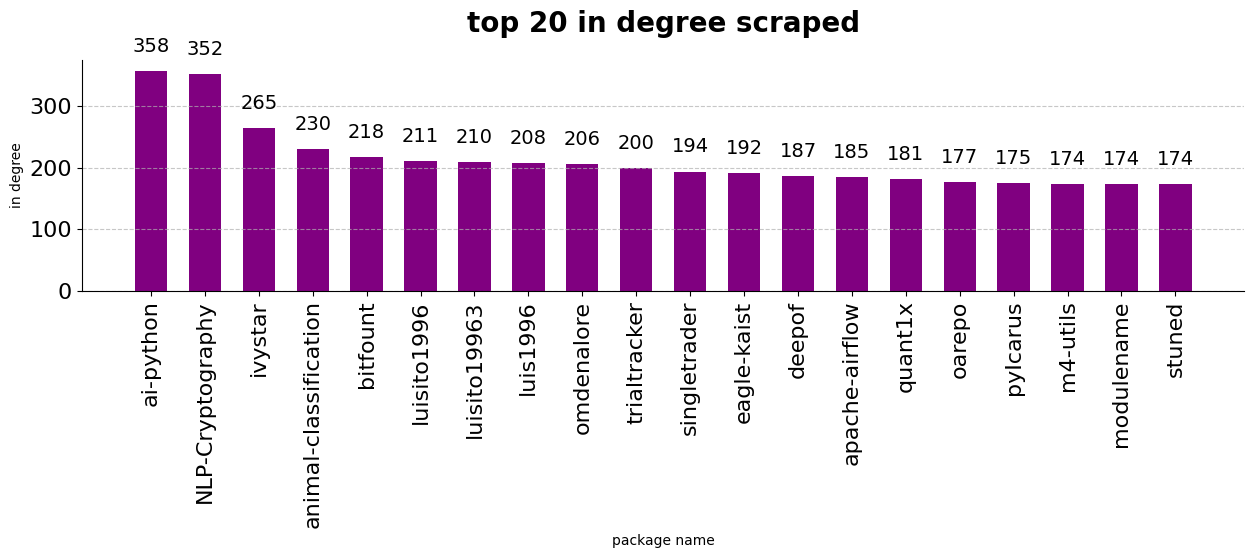

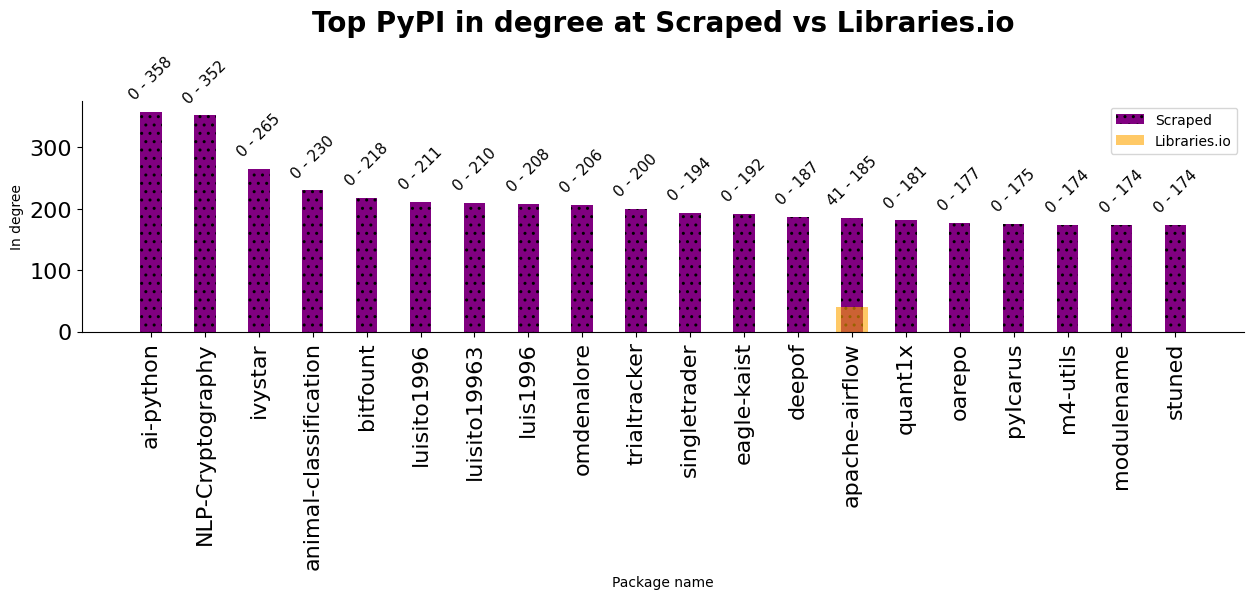

In [ ]:
scraped_t20_ind = sorted(scraped_G.in_degree(), key=lambda x: x[1], reverse=True)[:20]

plot_dict(
    d = dict(scraped_t20_ind),
    title = 'top 20 in degree scraped',
    xlabel = 'package name',
    ylabel = 'in degree',
    rotation = 0,
    size = (15, 3),
    offset = 40,
    label_size = 16,
    font_size = 14,
    label_rotation = 90,
    color = 'purple',
    w=0.6
)

plot_comparison_reversed(
    ss = scraped_t20_ind,
    tt_G =librariesio_G,
    save=True,
    filename=f'{OUT_IMG_DIR}/scraped_t20_ind_comparison.png',
    xticks_rotation=90,
    bar_offset=20,
    xticks_size=16,
    font_size=11,
    rotation=45,
    tittle=f'Top {REPO_NAME} in degree at Scraped vs Libraries.io',
    metric='In degree',
    comparable=librariesio_G.in_degree(),
)

##### Global in degree distribution

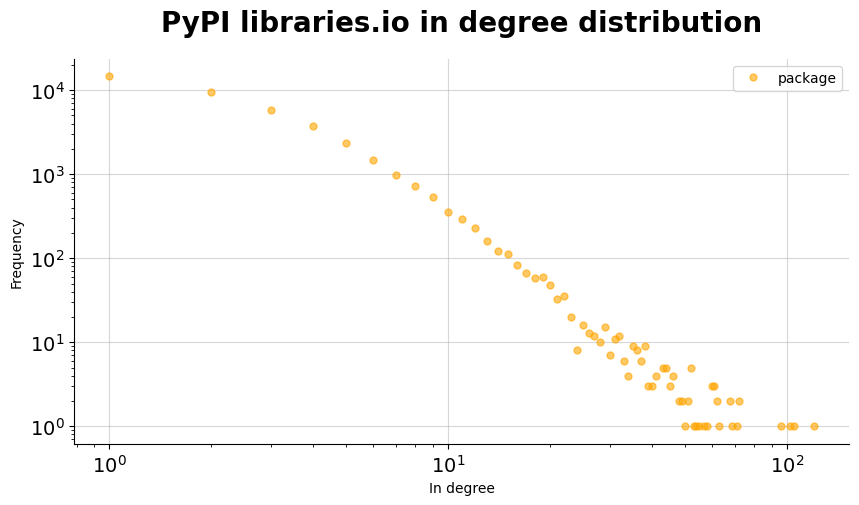

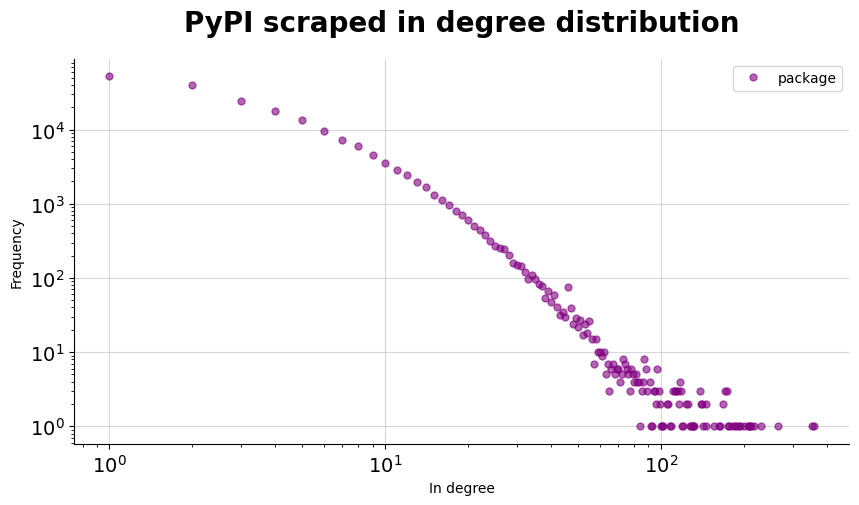

In [ ]:

libio_in_degree = [x[1] for x in librariesio_G.in_degree()]
plot_data(libio_in_degree, 'In degree', f'{REPO_NAME} libraries.io in degree distribution', 'orange')

scraped_in_degree = [x[1] for x in scraped_G.in_degree()]
plot_data(scraped_in_degree, 'In degree', f'{REPO_NAME} scraped in degree distribution', 'purple')

#### **4 - Pagerrank**

##### Evolution

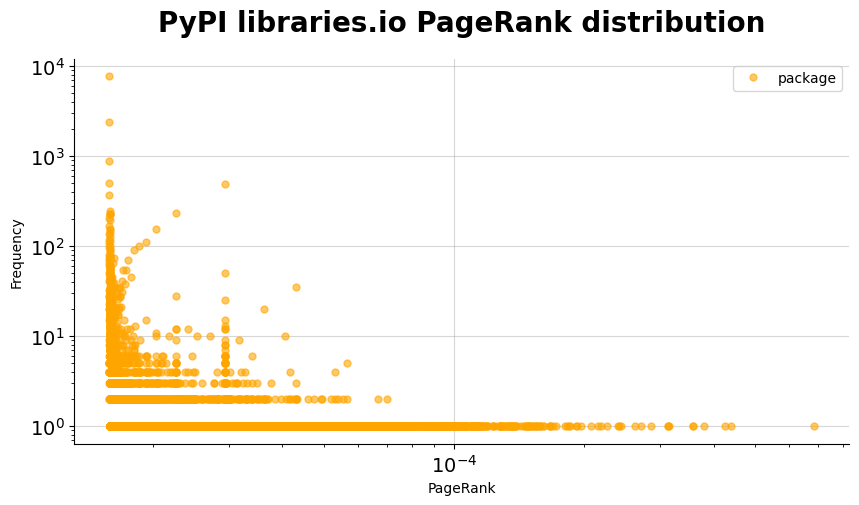

In [ ]:
libio_pagerank = list(dict(nx.pagerank(librariesio_G)).values())

plot_data(
    libio_pagerank,
    'PageRank',
    f'{REPO_NAME} libraries.io PageRank distribution',
    'orange'
)


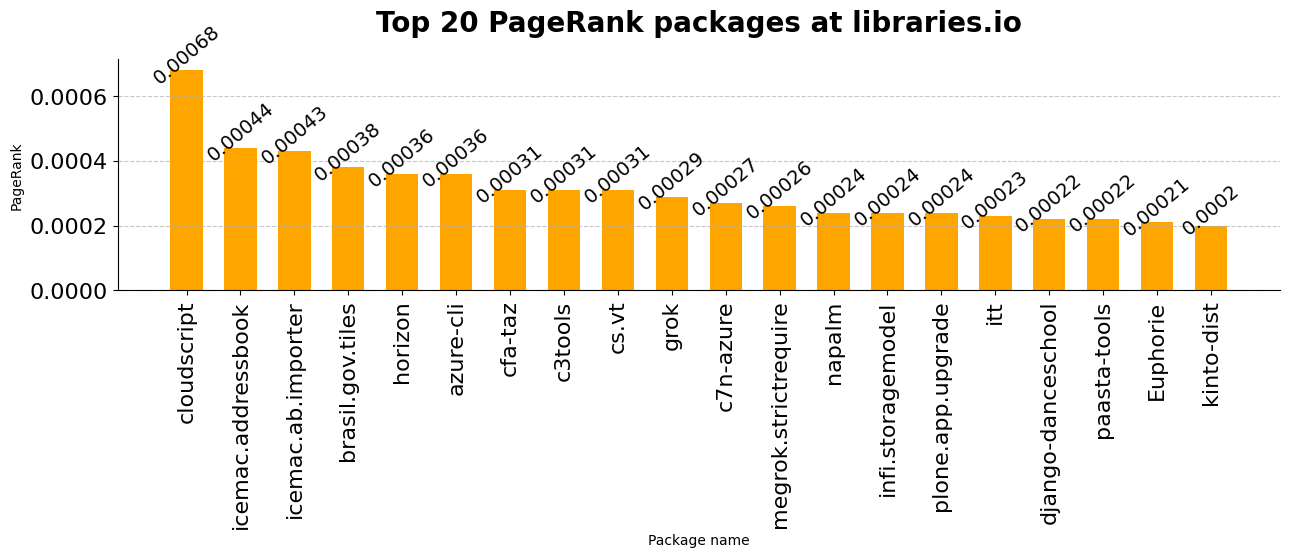

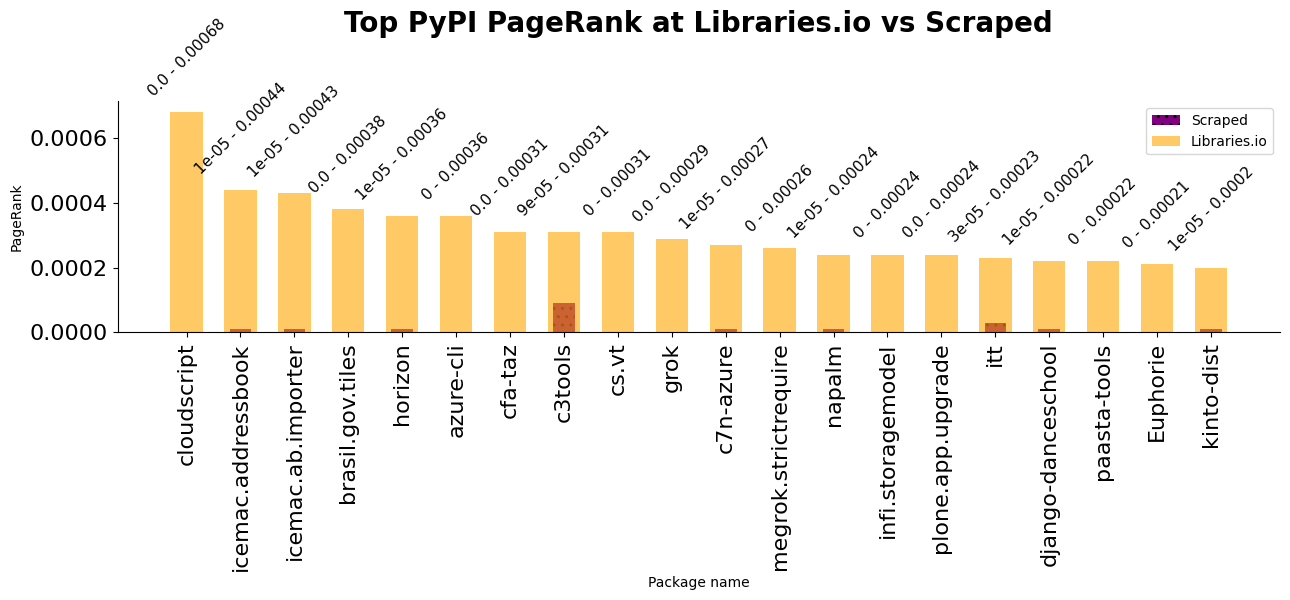

In [ ]:
# Top 20 PageRank 
# ---------------

libio_t20_pr = sorted(nx.pagerank(librariesio_G).items(), key=lambda x: x[1], reverse=True)[:20]
libio_t20_pr = [(x[0], round(x[1], 5)) for x in libio_t20_pr]

plot_dict(
    d = dict(libio_t20_pr),
    title = 'Top 20 PageRank packages at libraries.io',
    xlabel = 'Package name',
    ylabel = 'PageRank',
    rotation = 40,
    size = (15, 3),
    offset = 0.00005,
    label_size = 16,
    font_size = 14,
    label_rotation = 90,
    w=0.6
)


pr = nx.pagerank(scraped_G)
pr = {k: round(v, 5) for k, v in pr.items()}

plot_comparison(
    ss = libio_t20_pr,
    tt_G = scraped_G,
    save=True,
    filename=f'{OUT_IMG_DIR}/libio_t20_pr_comparison.png',
    xticks_rotation=90,
    bar_offset=0.00005,
    xticks_size=16,
    font_size=11,
    rotation=45,
    tittle=f'Top {REPO_NAME} PageRank at Libraries.io vs Scraped',
    metric='PageRank',
    comparable=pr
)

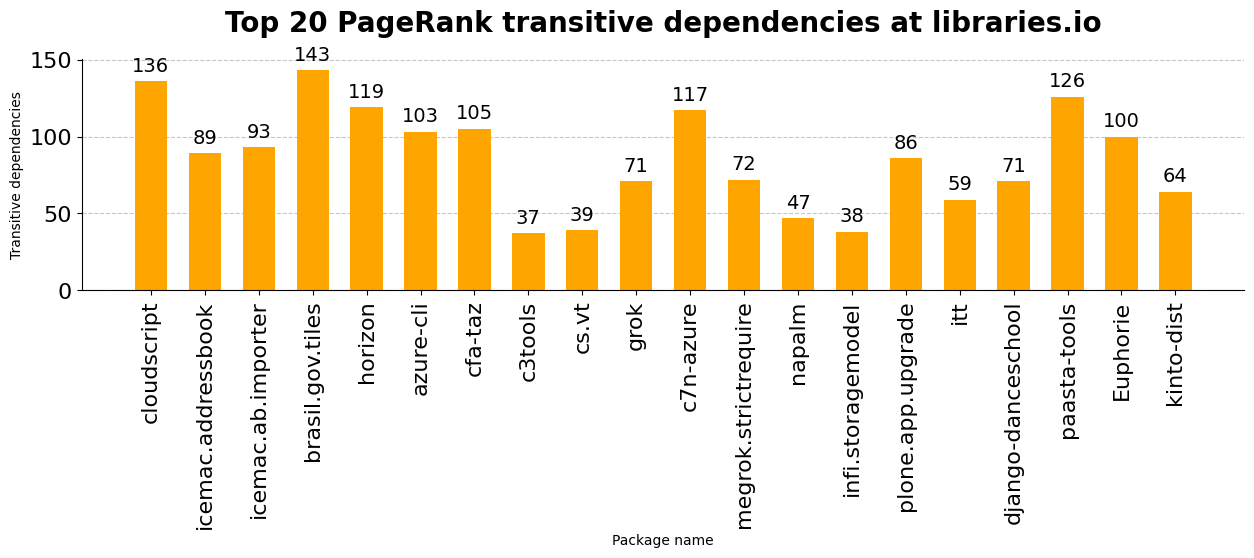

In [ ]:
# Top 20 PageRank transitive dependencies at libraries.io
# -------------------------------------------------------


keys = [x[0] for x in libio_t20_pr]

# get transitive dependencies for each package
transitive_dependencies = {}
for k in keys:

    len_k = len(librariesio_model[k].transitive_dependencies())
    transitive_dependencies[k] = len_k


plot_dict(
    d = transitive_dependencies,
    title = 'Top 20 PageRank transitive dependencies at libraries.io',
    xlabel = 'Package name',
    ylabel = 'Transitive dependencies',
    rotation = 0,
    offset=10,
    size = (15, 3),
    label_size = 16,
    font_size = 14,
    label_rotation = 90,
    w=0.6
)
    

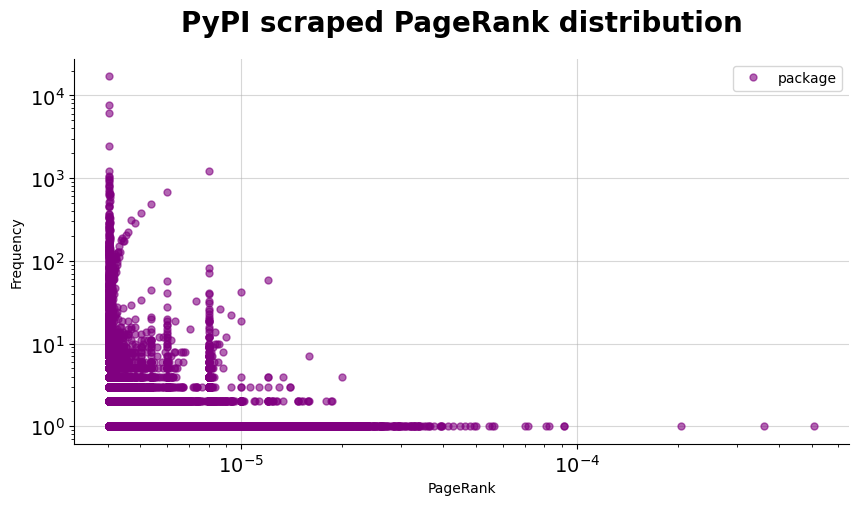

In [ ]:
# Pagerank distribution
# ---------------------

# Libraries.io
scraped_pagerank = list(dict(nx.pagerank(scraped_G)).values())
plot_data(scraped_pagerank, 'PageRank', f'{REPO_NAME} scraped PageRank distribution', 'purple')

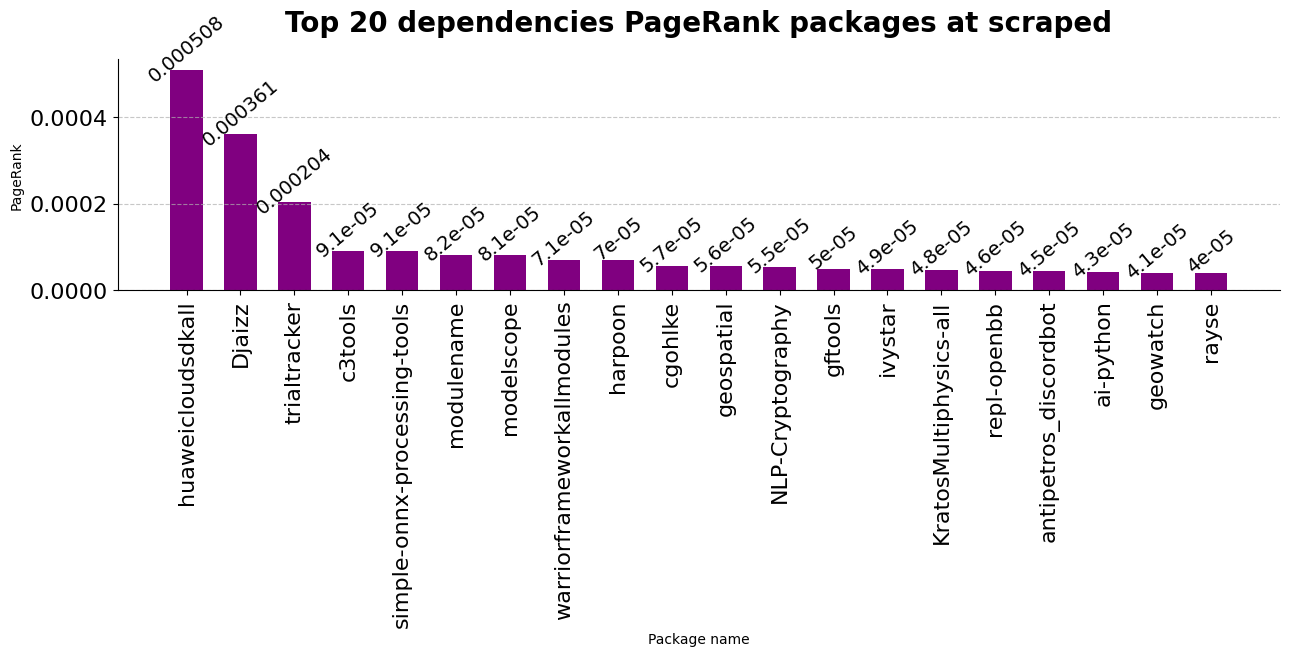

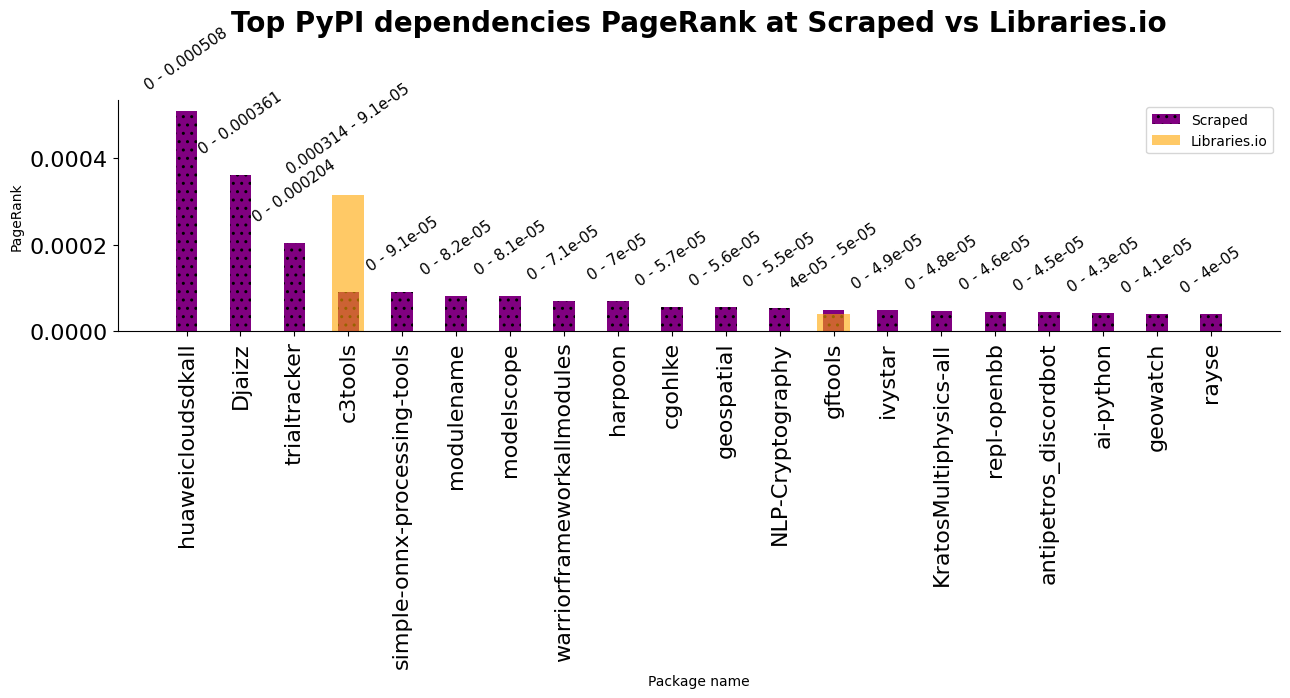

In [ ]:
scraped_t20_pr = sorted(nx.pagerank(scraped_G).items(), key=lambda x: x[1], reverse=True)[:20]
scraped_t20_pr = [(x[0], round(x[1], 6)) for x in scraped_t20_pr]

plot_dict(
    d = dict(scraped_t20_pr),
    title = 'Top 20 dependencies PageRank packages at scraped',
    xlabel = 'Package name',
    ylabel = 'PageRank',
    rotation = 40,
    size = (15, 3),
    offset = 0.00005,
    label_size = 16,
    font_size = 14,
    label_rotation = 90,
    w=0.6,
    color='purple'
)


# Plot evolution of top PageRank scraped packages
# ---------------------------------------------------

# Get PageRank of each node of top PageRank scraped using the libraries.io graph
pr = nx.pagerank(librariesio_G)

plot_comparison_reversed(
    ss = scraped_t20_pr,
    tt_G = librariesio_G,
    save=True,
    filename=f'{OUT_IMG_DIR}/scraped_t20_pr_comparison.png',
    xticks_rotation=90,
    bar_offset=0.00005,
    xticks_size=16,
    font_size=11,
    rotation=35,
    tittle=f'Top {REPO_NAME} dependencies PageRank at Scraped vs Libraries.io',
    metric='PageRank',
    comparable={k: round(v, 6) for k, v in pr.items()}
)



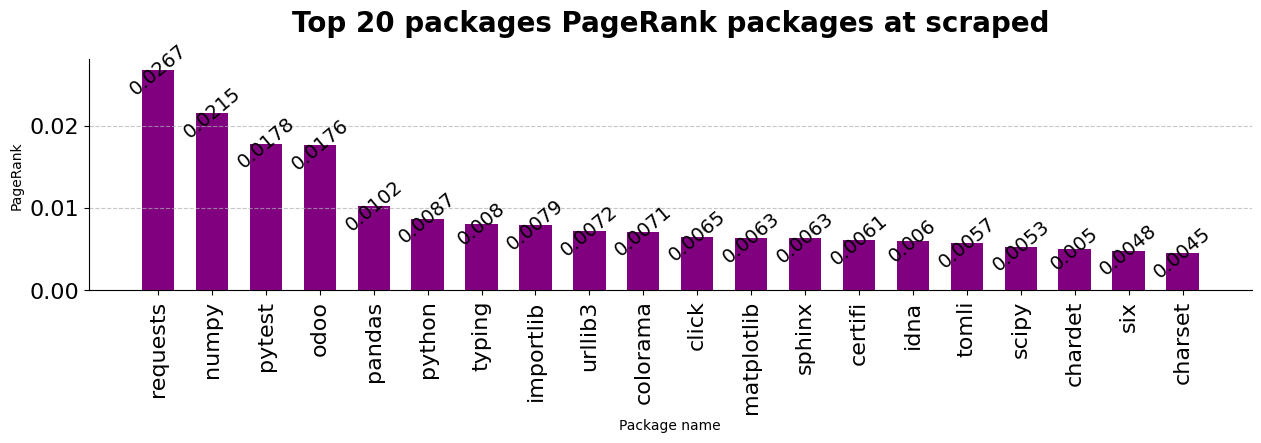

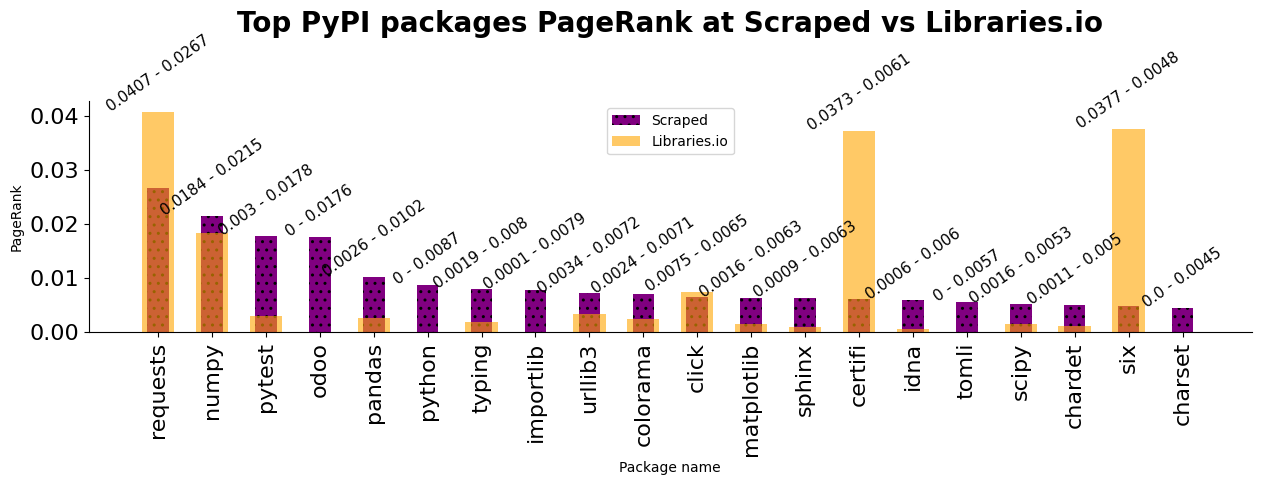

In [ ]:
scraped_t20_pr = sorted(nx.pagerank(scraped_G.reverse()).items(), key=lambda x: x[1], reverse=True)[:20]
scraped_t20_pr = [(x[0], round(x[1], 4)) for x in scraped_t20_pr]

plot_dict(
    d = dict(scraped_t20_pr),
    title = 'Top 20 packages PageRank packages at scraped',
    xlabel = 'Package name',
    ylabel = 'PageRank',
    rotation = 40,
    size = (15, 3),
    offset = 0.0001,
    label_size = 16,
    font_size = 14,
    label_rotation = 90,
    w=0.6,
    color='purple'
)


# Plot evolution of top PageRank scraped packages
# ---------------------------------------------------

# Get PageRank of each node of top PageRank scraped using the libraries.io graph
pr = nx.pagerank(librariesio_G.reverse())

plot_comparison_reversed(
    ss = scraped_t20_pr,
    tt_G = librariesio_G.reverse(),
    save=True,
    filename=f'{OUT_IMG_DIR}/scraped_t20_pr_comparison.png',
    xticks_rotation=90,
    bar_offset=0.0001,
    xticks_size=16,
    font_size=11,
    rotation=35,
    tittle=f'Top {REPO_NAME} packages PageRank at Scraped vs Libraries.io',
    metric='PageRank',
    comparable={k: round(v, 4) for k, v in pr.items()}
)


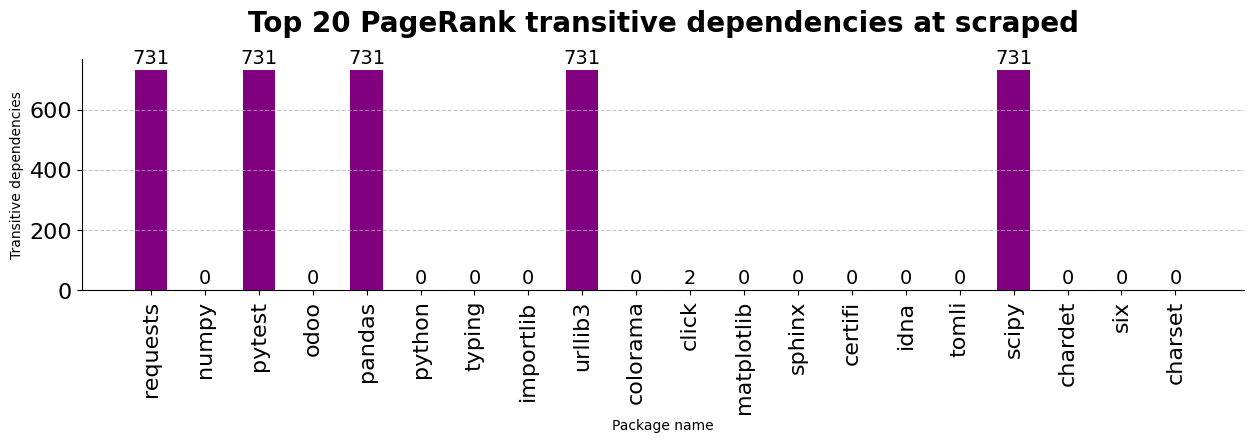

In [ ]:
# Top 20 PageRank transitive dependencies at libraries.io
# -------------------------------------------------------


keys = [x[0] for x in scraped_t20_pr]

# get transitive dependencies for each package
transitive_dependencies = {}
for k in keys:

    len_k = len(scraped_model[k].transitive_dependencies())
    transitive_dependencies[k] = len_k


plot_dict(
    d = transitive_dependencies,
    title = 'Top 20 PageRank transitive dependencies at scraped',
    xlabel = 'Package name',
    ylabel = 'Transitive dependencies',
    color='purple',
    rotation = 0,
    offset=40,
    size = (15, 3),
    label_size = 16,
    font_size = 14,
    label_rotation = 90,
    w=0.6
)
    

We can compare other interesting metrics as well.

### **Olivia metrics**

#### **1 - Atack vulnerability**

In [ ]:
from olivia.networkmetrics import attack_vulnerability

librariesio_model_attack_vulnerability = attack_vulnerability(librariesio_model, normalize=True)
scraped_model_attack_vulnerability = attack_vulnerability(scraped_model, normalize=True)

print('Attack vulnerability librariesio: {}'.format(librariesio_model_attack_vulnerability))
print('Attack vulnerability scraped: {}'.format(scraped_model_attack_vulnerability))
print('Increase in attack vulnerability: {}'.format(scraped_model_attack_vulnerability - librariesio_model_attack_vulnerability))

Computing Reach


     Processing node: 49K      
Computing Reach
     Processing node: 213K      
Attack vulnerability librariesio: 0.38964831866304306
Attack vulnerability scraped: 0.6760852333659719
Increase in attack vulnerability: 0.28643691470292887


#### **2 - Failure vulnerability**

In [ ]:
from olivia.networkmetrics import failure_vulnerability

librariesio_model_failure_vulnerability = failure_vulnerability(librariesio_model, normalize=True)
scraped_model_failure_vulnerability = failure_vulnerability(scraped_model, normalize=True)

print('Failure vulnerability librariesio: {}'.format(librariesio_model_failure_vulnerability))
print('Failure vulnerability scraped: {}'.format(scraped_model_failure_vulnerability))
print('Increase in failure vulnerability: {}'.format(scraped_model_failure_vulnerability - librariesio_model_failure_vulnerability))

Reach retrieved from metrics cache
Reach retrieved from metrics cache
Failure vulnerability librariesio: 0.0001738793933286081
Failure vulnerability scraped: 0.0022826054428677265
Increase in failure vulnerability: 0.0021087260495391185


#### **3 - Reach**

In [ ]:
from olivia.packagemetrics import Reach

librariesio_reach = librariesio_model.get_metric(Reach)
scraped_reach = scraped_model.get_metric(Reach)

Reach retrieved from metrics cache
Reach retrieved from metrics cache


**Top reach**

######

In [ ]:
# Top 10 Reach
# ------------

top10_reach_librariesio = librariesio_reach.top(10)
top10_reach_scraped = scraped_reach.top(10)

# Top 10 Reach comparison
top10_reach_comparison = pd.DataFrame(
    {
        'librariesio': top10_reach_librariesio,
        'scraped': top10_reach_scraped
    }
)

top10_reach_comparison

librariesio              scraped
0             (six, 19212)      (numpy, 145000)
1         (certifi, 14155)  (importlib, 142309)
2        (requests, 13655)        (six, 142282)
3        (pyparsing, 8681)   (colorama, 142116)
4        (packaging, 8308)     (typing, 142045)
5          (appdirs, 7874)     (python, 142018)
6       (setuptools, 7340)      (click, 141302)
7  (python-dateutil, 6592)    (chardet, 140543)
8            (numpy, 4937)     (django, 140508)
9            (attrs, 4311)     (Cython, 140502)

**Bottomb reach**

######

In [ ]:
# Top 10 least Reach
# ------------------

top10_least_reach_librariesio = librariesio_reach.bottom(10)
top10_least_reach_scraped = scraped_reach.bottom(10)

# Top 10 least Reach comparison
top10_least_reach_comparison = pd.DataFrame(
    {
        'librariesio': top10_least_reach_librariesio,
        'scraped': top10_least_reach_scraped
    }
)

top10_least_reach_comparison

librariesio                 scraped
0           (pytest-testdox, 1)       (lol-id-tools, 1)
1       (pytest-json-report, 1)           (logipass, 1)
2      (pytest-random-order, 1)             (loghub, 1)
3           (pytest-twisted, 1)      (lodek-bookman, 1)
4  (pytest-markers-presence, 1)           (lockdoor, 1)
5              (pytest-only, 1)  (llamazure.azgraph, 1)
6                 (nutsflow, 1)         (livyclient, 1)
7                   (mydict, 1)       (livingmodels, 1)
8           (optimuspyspark, 1)      (littlefieldpy, 1)
9                    (1pass, 1)      (0x-sra-client, 1)

**Top reach increase, decrease and variation**

######

In [ ]:
# Dataframe with the differences between the two models
librariesio_reach_df = pd.DataFrame(librariesio_reach.results_dict, index=['librariesio']).T
scraped_reach_df = pd.DataFrame(scraped_reach.results_dict, index=['scraped']).T

reach_df = pd.concat([librariesio_reach_df, scraped_reach_df], axis=1)
reach_df['increment'] = reach_df['scraped'] - reach_df['librariesio']
reach_df.sort_values(by='increment', ascending=False, inplace=True)
reach_df.head(10)

librariesio   scraped  increment
importlib              24.0  142309.0   142285.0
typing               1414.0  142045.0   140631.0
colorama             1531.0  142116.0   140585.0
Cython                 74.0  140502.0   140428.0
genshi                  5.0  140394.0   140389.0
BeautifulSoup4         70.0  140393.0   140323.0
cssselect             239.0  140393.0   140154.0
html5lib              254.0  140386.0   140132.0
numpy                4937.0  145000.0   140063.0
webencodings          733.0  140387.0   139654.0

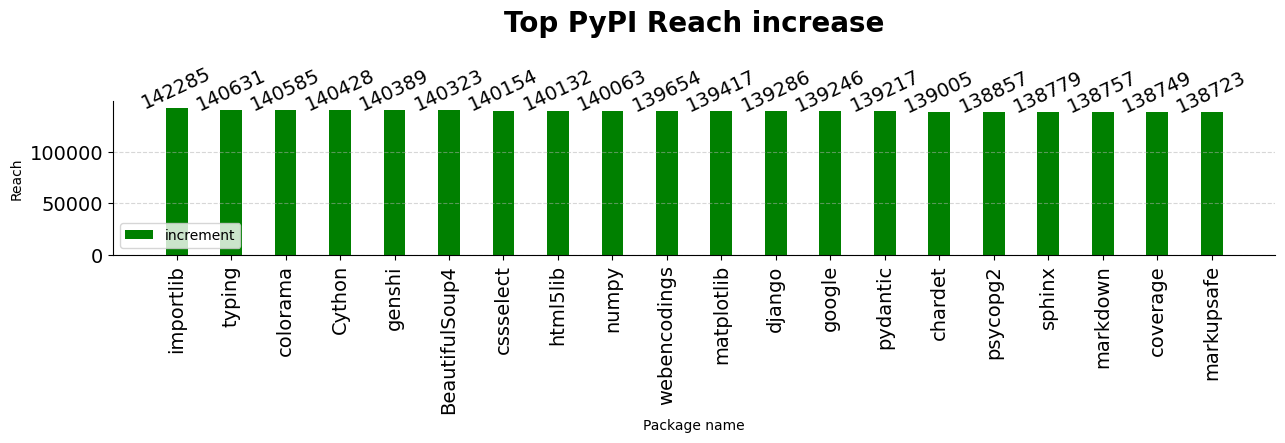

In [ ]:
# Top reach increase
# ------------------

increment = reach_df.head(20)

# Plot top reach increase
plt.figure(figsize=(15, 2))

plt.bar(
    increment.index,
    increment['increment'],
    label='increment',
    color='green',
    width=0.4,
)

for i, v in zip(increment.index, increment['increment']):
    plt.text(i, v, f'{int(v)}', color='black', ha='center', rotation=25, fontsize=14)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=90)
plt.gca().tick_params(axis='y', labelsize=14)

plt.title(f'Top {REPO_NAME} Reach increase', fontsize=20, fontweight='bold', pad=50)
plt.xlabel('Package name')
plt.ylabel('Reach')
plt.legend(loc='lower left')
# grid
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.savefig(f'{OUT_IMG_DIR}/top_reach_increase.png', bbox_inches='tight')
plt.show()


/tmp/ipykernel_142604/773171109.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decrement.sort_values(by='increment', ascending=True, inplace=True)


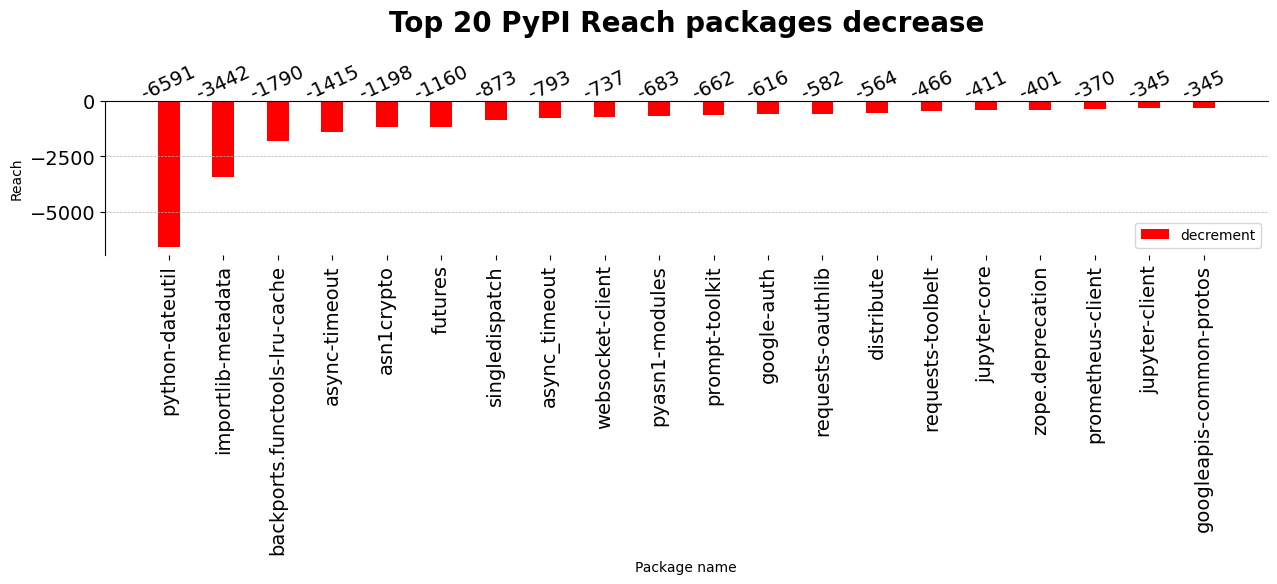

In [ ]:
# Decrease in Reach
reach_df = reach_df.dropna()
decrement = reach_df.tail(20)

# sort by increment
decrement.sort_values(by='increment', ascending=True, inplace=True)

# Plot
plt.figure(figsize=(15, 2))

plt.bar(
    decrement.index,
    decrement['increment'],
    label='decrement',
    color='red',
    width=0.4,
)

for i, v in zip(decrement.index, decrement['increment']):
    plt.text(i, 100, f'{int(v)}', color='black', ha='center', rotation=25, fontsize=14)

# Adjusting plot borders
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=90)
plt.gca().tick_params(axis='y', labelsize=14)
plt.title(f'Top 20 {REPO_NAME} Reach packages decrease', fontsize=20, fontweight='bold', pad=50)
plt.xlabel('Package name')
plt.ylabel('Reach')
plt.legend()
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()


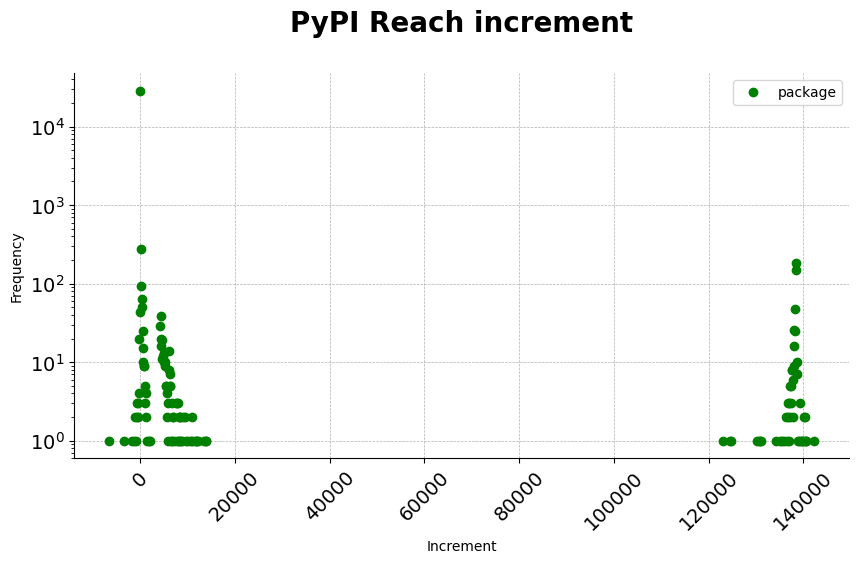

In [ ]:
# Reach variation
# ---------------

reach_increment = list(reach_df['increment'].dropna())

# Plot list of reach increase
plt.figure(figsize=(10, 5))

# agrupar em intervalos de 100
reach_increment = [int(x / 100) * 100 for x in reach_increment]
x, y = zip(*Counter(reach_increment).items())

plt.plot(x, y, color='green', marker='o', linestyle='None', label="package")

plt.title(f'{REPO_NAME} Reach increment', fontsize=20, fontweight='bold', pad=30)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=45)
plt.gca().tick_params(axis='y', labelsize=14)
plt.xlabel('Increment')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xscale('linear')
plt.yscale('log')
plt.show()

**Reach evolution**

######

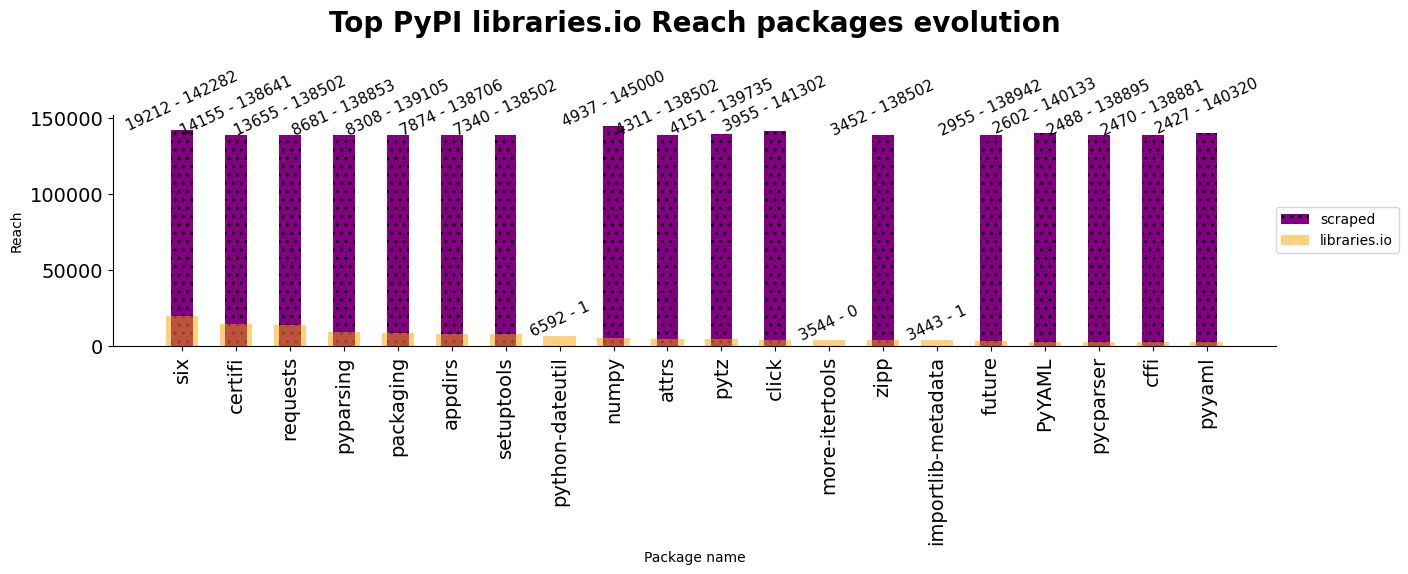

In [ ]:

# Top librariesio reach evolution 
# --------------------------------

# Get the top 10 packages with the highest Reach in the libraries.io model
top_reach_librariesio = dict(librariesio_reach.top(20))

# Get the Reach of the packages in the scraped model
top_reach_scraped = {}
reach_scraped = scraped_reach.results_dict
for package in top_reach_librariesio.keys():
    if package in reach_scraped.keys():
        top_reach_scraped[package] = reach_scraped[package]
    else:
        top_reach_scraped[package] = 0


# Plot comparison
plt.figure(figsize=(15, 3))

plt.bar(
    [x[0] for x in top_reach_scraped.items()],
    [x[1] for x in top_reach_scraped.items()],
    label='scraped',
    color='purple',
    width=0.4,
    hatch='..'
)

plt.bar(
    [x[0] for x in top_reach_librariesio.items()],
    [x[1] for x in top_reach_librariesio.items()],
    label='libraries.io',
    color='orange',
    width=0.6,
    alpha=0.5,
)

for i, v, i2, v2 in zip([x[0] for x in top_reach_librariesio.items()], [x[1] for x in top_reach_librariesio.items()], [x[0] for x in top_reach_scraped.items()], [x[1] for x in top_reach_scraped.items()]):
    plt.text(i, max(v,v2)+0.0005, f'{v} - {v2}', color='black', ha='center', rotation=25, fontsize=11)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=90)
plt.gca().tick_params(axis='y', labelsize=14)
plt.title(f'Top {REPO_NAME} libraries.io Reach packages evolution', fontsize=20, fontweight='bold', pad=60)
plt.xlabel('Package name')
plt.ylabel('Reach')
plt.legend(loc=(1, 0.4))

plt.savefig(f'{OUT_IMG_DIR}/top_librariesio_reach_evolution.png', bbox_inches='tight')
plt.show()

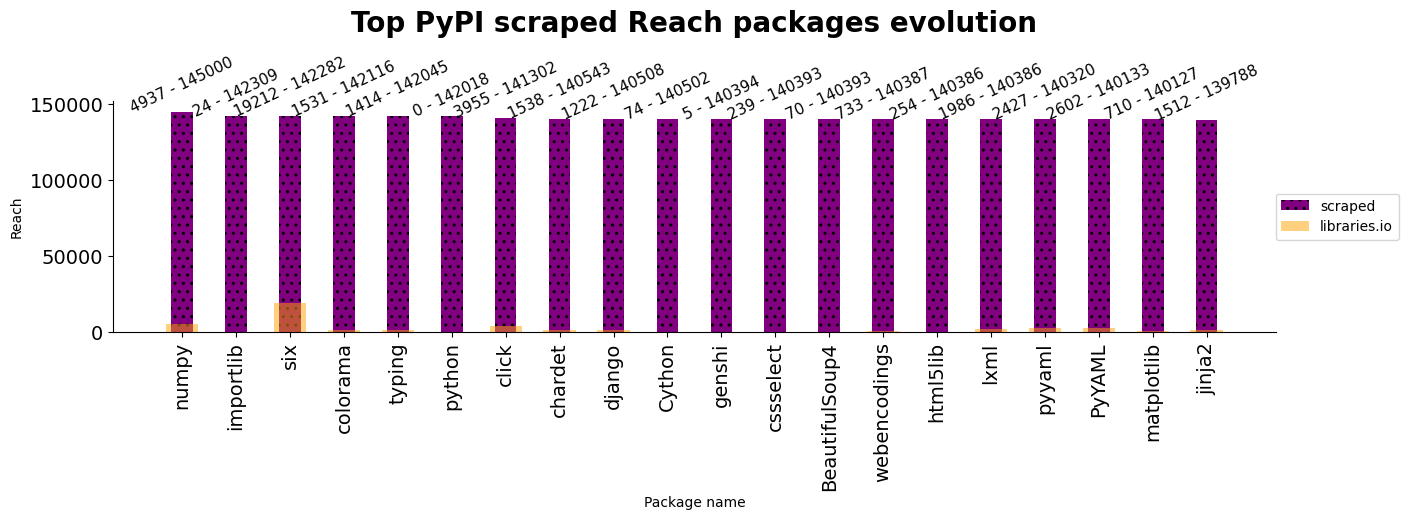

In [ ]:
# Top scraped reach evolution
# ----------------------------

# Get the top 10 packages with the highest Reach in the scraped model
top_reach_scraped = dict(scraped_reach.top(20))

# Get the Reach of the packages in the libraries.io model
top_reach_librariesio = {}
reach_librariesio = librariesio_reach.results_dict
for package in top_reach_scraped.keys():
    if package in reach_librariesio.keys():
        top_reach_librariesio[package] = reach_librariesio[package]
    else:
        top_reach_librariesio[package] = 0


# Plot comparison
plt.figure(figsize=(15, 3))
plt.bar(
    [x[0] for x in top_reach_scraped.items()],
    [x[1] for x in top_reach_scraped.items()],
    label='scraped',
    color='purple',
    width=0.4,
    hatch='..'
)
plt.bar(
    [x[0] for x in top_reach_librariesio.items()],
    [x[1] for x in top_reach_librariesio.items()],
    label='libraries.io',
    color='orange',
    width=0.6,
    alpha=0.5,
)

for i, v, i2, v2 in zip([x[0] for x in top_reach_librariesio.items()], [x[1] for x in top_reach_librariesio.items()], [x[0] for x in top_reach_scraped.items()], [x[1] for x in top_reach_scraped.items()]):
    plt.text(i, max(v,v2)+0.0005, f'{v} - {v2}', color='black', ha='center', rotation=25, fontsize=11)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=90)
plt.gca().tick_params(axis='y', labelsize=14)
plt.title(f'Top {REPO_NAME} scraped Reach packages evolution', fontsize=20, fontweight='bold', pad=50)
plt.xlabel('Package name')
plt.ylabel('Reach')
plt.legend(loc=(1, 0.4))

plt.savefig(f'{OUT_IMG_DIR}/top_scraped_reach_evolution.png', bbox_inches='tight')
plt.show()


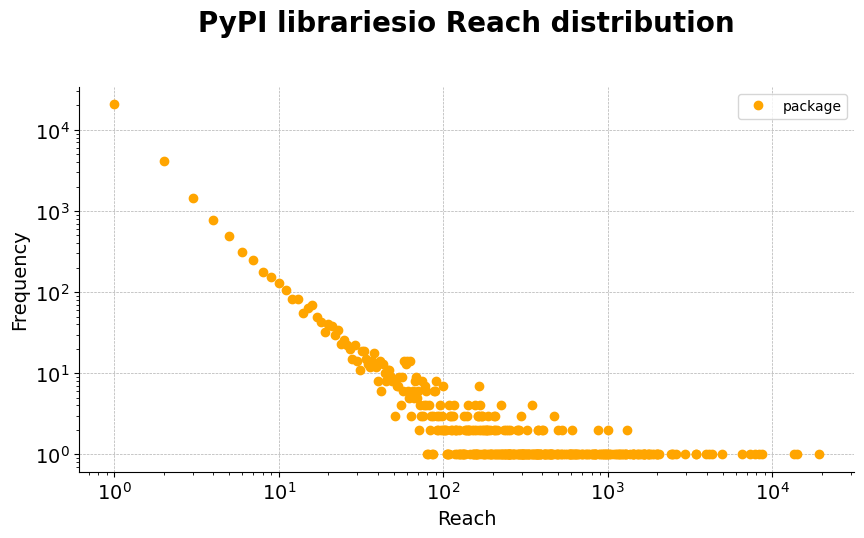

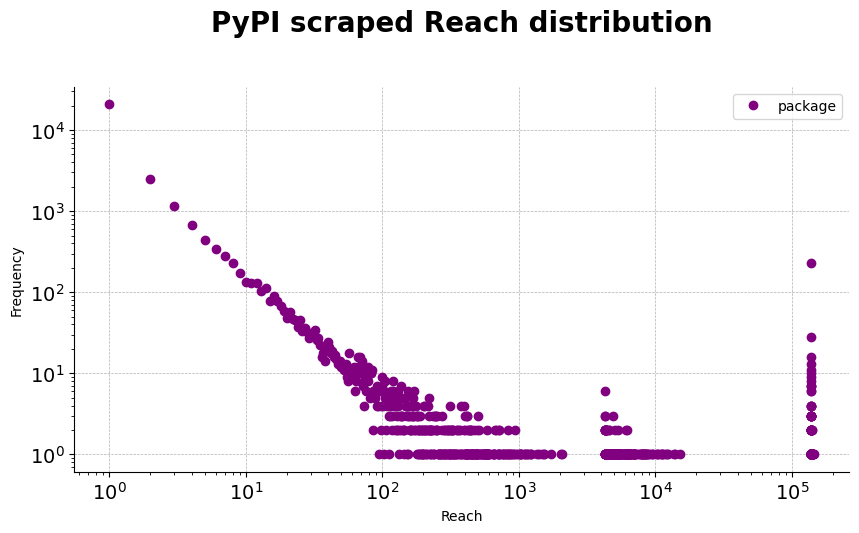

In [ ]:
# Reach distribution for libraries.io
# -----------------------------------

# Plot distribution
plt.figure(figsize=(10, 5))
reach = list(reach_df['librariesio'].dropna())
x, y = zip(*Counter(reach).items())

plt.plot(x, y, color='orange', marker='o', linestyle='None', label="package")

plt.title(f'{REPO_NAME} librariesio Reach distribution', fontsize=20, fontweight='bold', pad=40)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14)
plt.gca().tick_params(axis='y', labelsize=14)
plt.xlabel('Reach', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xscale('log')
plt.yscale('log')

plt.savefig(f'{OUT_IMG_DIR}/librariesio_reach_distribution.png', bbox_inches='tight')
plt.show()


# Reach distribution for scraped
# -----------------------------

# Plot distribution
plt.figure(figsize=(10, 5))
reach = list(reach_df['scraped'].dropna())
x, y = zip(*Counter(reach).items())

plt.plot(x, y, color='purple', marker='o', linestyle='None', label="package")

plt.title(f'{REPO_NAME} scraped Reach distribution', fontsize=20, fontweight='bold', pad=40)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14)
plt.gca().tick_params(axis='y', labelsize=14)
plt.xlabel('Reach')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xscale('log')
plt.yscale('log')

plt.savefig(f'{OUT_IMG_DIR}/scraped_reach_distribution.png', bbox_inches='tight')
plt.show()



#### **4 - Impact**

In [ ]:
from olivia.packagemetrics import Impact

librariesio_impact = librariesio_model.get_metric(Impact)
scraped_impact = scraped_model.get_metric(Impact)

Computing Impact
     Processing node: 49K      
Computing Impact
     Processing node: 213K      


**Top impact**

######

In [ ]:
# Top 10 impact
# -------------

top10_impact_librariesio = librariesio_impact.top(10)
top10_impact_scraped = scraped_impact.top(10)

# Top 10 impact comparison
top10_impact_comparison = pd.DataFrame(
    {
        'librariesio': top10_impact_librariesio,
        'scraped': top10_impact_scraped
    }
)

top10_impact_comparison

librariesio               scraped
0             (six, 36757)       (numpy, 448177)
1         (certifi, 18739)         (six, 424014)
2        (requests, 17740)      (python, 422180)
3       (pyparsing, 14111)   (importlib, 420861)
4       (packaging, 13433)      (typing, 417287)
5         (appdirs, 12619)    (colorama, 416663)
6      (setuptools, 11803)  (matplotlib, 414520)
7  (python-dateutil, 9825)     (chardet, 413067)
8            (numpy, 7396)      (Cython, 412181)
9             (pytz, 6878)       (click, 411954)

**Bottom impact**

######

In [ ]:
# Top 10 less impact
# ------------------

top10_less_impact_librariesio = librariesio_impact.bottom(10)
top10_less_impact_scraped = scraped_impact.bottom(10)

# Top 10 less impact comparison
top10_less_impact_comparison = pd.DataFrame(
    {
        'librariesio': top10_less_impact_librariesio,
        'scraped': top10_less_impact_scraped
    }
)

top10_less_impact_comparison

librariesio                         scraped
0           (pytest-testdox, 0)                (LogReporter, 0)
1       (pytest-json-report, 0)             (LogoRestClient, 0)
2      (pytest-random-order, 0)                 (logger-hub, 0)
3           (pytest-twisted, 0)         (lockdoor-framework, 0)
4  (pytest-markers-presence, 0)  (location-ipfire-db-reader, 0)
5              (pytest-only, 0)                  (load-m3u8, 0)
6                 (nutsflow, 0)                 (llmapi-cli, 0)
7                   (mydict, 0)                   (lixinAPI, 0)
8           (optimuspyspark, 0)                  (liveatlas, 0)
9                    (1pass, 0)              (0x-sra-client, 0)

**Top impact increase, decrease y variation**

######

In [ ]:
# Dataframe with the increments between the two models
librariesio_impact_df = pd.DataFrame(librariesio_impact.results_dict, index=['librariesio']).T
scraped_impact_df = pd.DataFrame(scraped_impact.results_dict, index=['scraped']).T

impact_df = pd.concat([librariesio_impact_df, scraped_impact_df], axis=1)
impact_df['increment'] = impact_df['scraped'] - impact_df['librariesio']
impact_df.sort_values(by='increment', ascending=False, inplace=True)
impact_df.head(10)

librariesio   scraped  increment
numpy                7396.0  448177.0   440781.0
importlib              24.0  420861.0   420837.0
colorama             1795.0  416663.0   414868.0
typing               2434.0  417287.0   414853.0
matplotlib            748.0  414520.0   413772.0
Cython                 75.0  412181.0   412106.0
chardet              1707.0  413067.0   411360.0
BeautifulSoup4         75.0  411391.0   411316.0
genshi                  5.0  411290.0   411285.0
cssselect             260.0  411490.0   411230.0

<Figure size 1500x300 with 0 Axes>

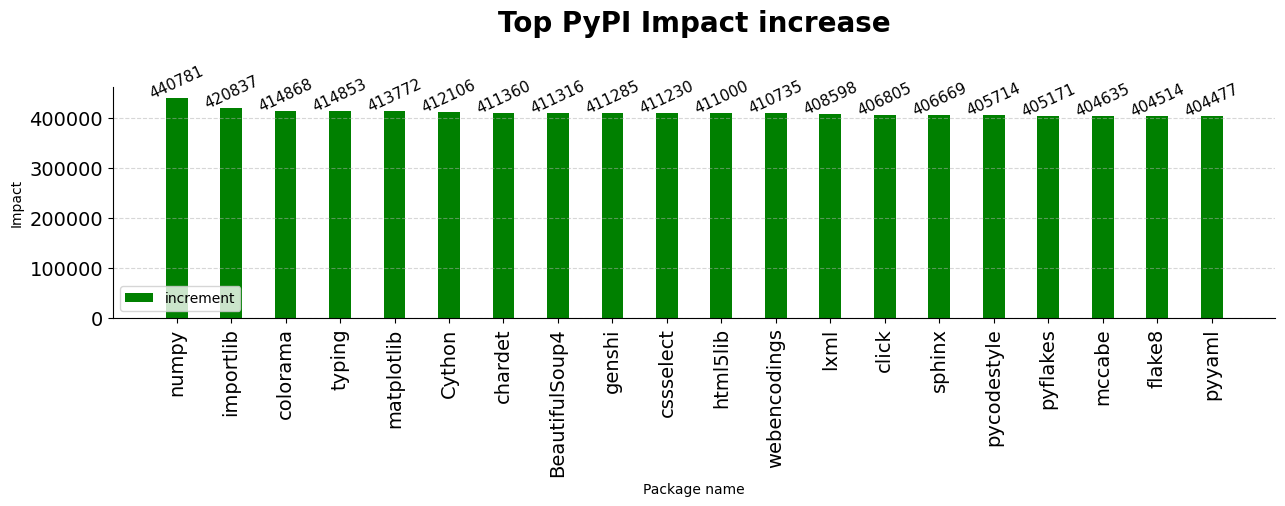

In [ ]:
# Plot increment
plt.figure(figsize=(15, 3))
increment = impact_df.head(20)

# Plot top reach increase
plt.figure(figsize=(15, 3))

plt.bar(
    increment.index,
    increment['increment'],
    label='increment',
    color='green',
    width=0.4,
)

for i, v in zip(increment.index, increment['increment']):
    plt.text(i, v, f'{int(v)}', color='black', ha='center', rotation=25, fontsize=11)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=90)
plt.gca().tick_params(axis='y', labelsize=14)

plt.title(f'Top {REPO_NAME} Impact increase', fontsize=20, fontweight='bold', pad=40)
plt.xlabel('Package name')
plt.ylabel('Impact')
plt.legend(loc='lower left')
# grid
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


**Top impact decrease**

######

In [ ]:
# Decrease in impact
impact_df = impact_df.dropna()
impact_df.tail(10)

librariesio  scraped  increment
pyasn1-modules                      1101.0      0.0    -1101.0
singledispatch                      1213.0     87.0    -1126.0
oslo.utils                          1242.0      0.0    -1242.0
futures                             2277.0    816.0    -1461.0
oslo.i18n                           1503.0      0.0    -1503.0
asn1crypto                          2503.0    817.0    -1686.0
async-timeout                       1828.0      0.0    -1828.0
backports.functools-lru-cache       1944.0      0.0    -1944.0
importlib-metadata                  4677.0      0.0    -4677.0
python-dateutil                     9825.0      0.0    -9825.0

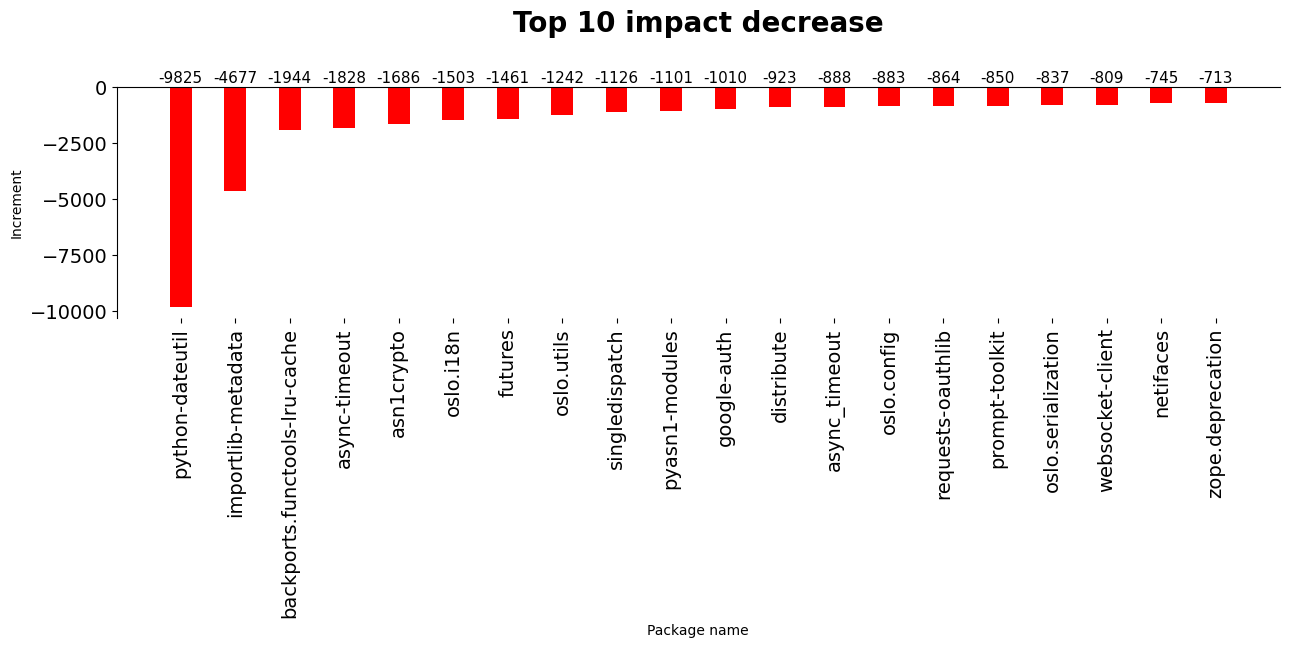

In [ ]:
# Plot decrease
plt.figure(figsize=(15, 3))
decrease = impact_df.tail(20).astype(int)

# sort by increment
decrease.sort_values(by='increment', ascending=True, inplace=True)

plt.bar(
    decrease.index,
    decrease['increment'],
    color='red',
    width=0.4,
)

for i, v in zip(decrease.index, decrease['increment']):
    plt.text(i, 200, f'{v}', color='black', ha='center', rotation=0, fontsize=11)

# Adjusting plot borders
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=90)
plt.gca().tick_params(axis='y', labelsize=14)

plt.title('Top 10 impact decrease', fontsize=20, fontweight='bold', pad=40)
plt.xlabel('Package name')
plt.ylabel('Increment')

plt.savefig(f'{OUT_IMG_DIR}/impact_decrease.png', bbox_inches='tight')
plt.show()


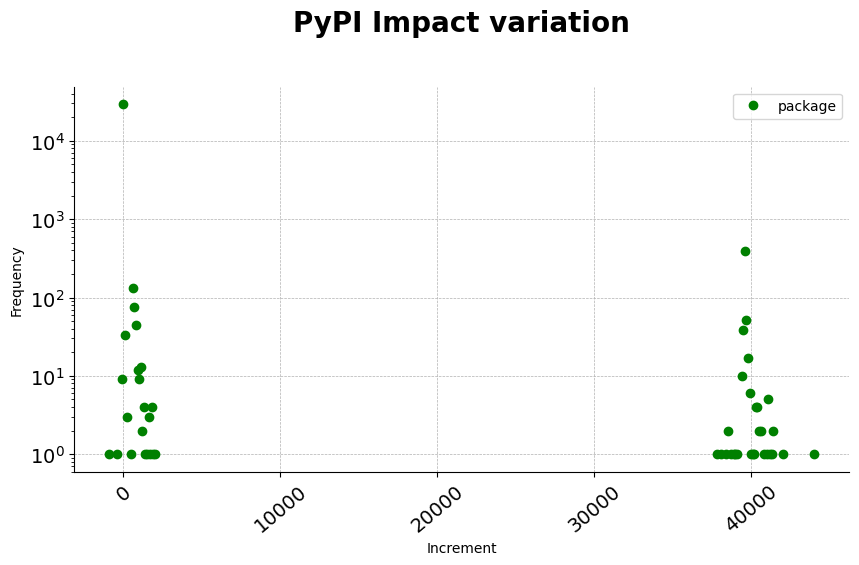

In [ ]:
# Reach variation
# ---------------

impact_increase = list(impact_df['increment'].dropna())
impact_increase.sort(reverse=True)

# Plot impact increase
plt.figure(figsize=(10, 5))

# agrupar em intervalos de 100
impact_increase = [int(x / 1000) * 100 for x in impact_increase]
x, y = zip(*Counter(impact_increase).items())

plt.plot(x, y, color='green', marker='o', linestyle='None', label='package')

plt.title(f'{REPO_NAME} Impact variation', fontsize=20, fontweight='bold', pad=40)

# Adjusting plot borders

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=40)
plt.gca().tick_params(axis='y', labelsize=14)
plt.ylabel('Frequency')
plt.xlabel('Increment')
plt.legend()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xscale('linear')
plt.yscale('log')
plt.show()

**Evolution**

######

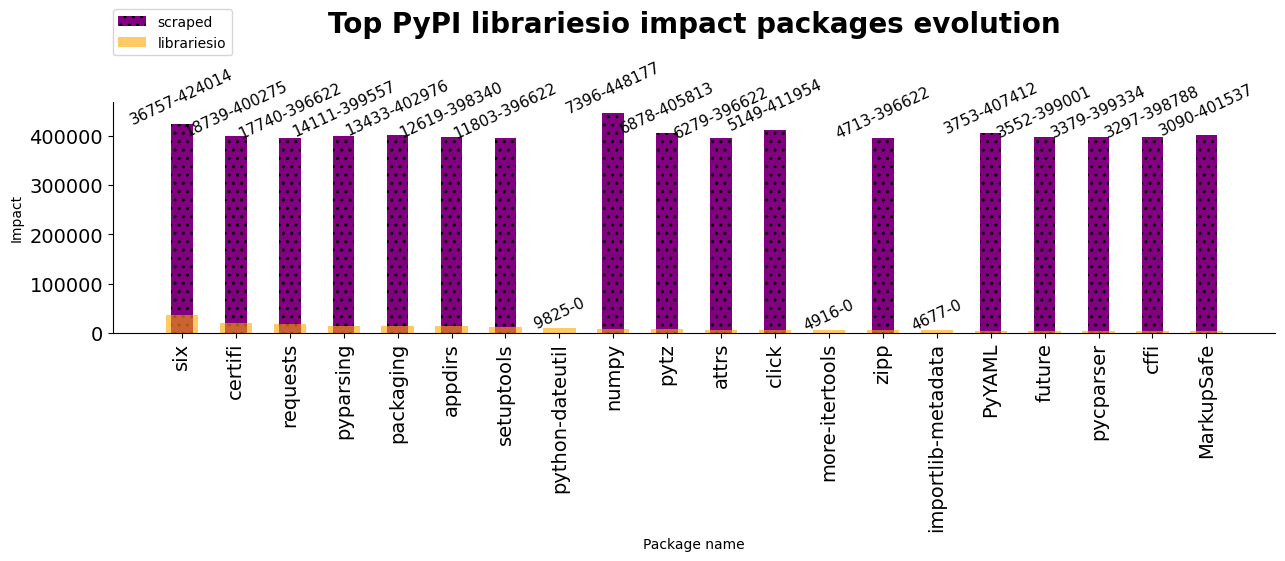

In [ ]:
# Top librariesio impact packages evolution
# -----------------------------------------

top_impact_librariesio = dict(librariesio_impact.top(20))

# Get the impact of the top librariesio packages in the scraped model
top_impact_scraped = {}
for package in top_impact_librariesio.keys():
    try:
        top_impact_scraped[package] = scraped_impact.results_dict[package]
    except KeyError:
        top_impact_scraped[package] = 0

# Plot top impact packages evolution
plt.figure(figsize=(15, 3))



plt.bar(
    [x[0] for x in top_impact_scraped.items()],
    [x[1] for x in top_impact_scraped.items()],
    label='scraped',
    color='purple',
    width=0.4,
    hatch='..'
)

plt.bar(
    [x[0] for x in top_impact_librariesio.items()],
    [x[1] for x in top_impact_librariesio.items()],
    label='librariesio',
    color='orange',
    width=0.6,
    alpha=0.6,
)

for i, v, v2 in zip([x[0] for x in top_impact_librariesio.items()], [x[1] for x in top_impact_librariesio.items()], [x[1] for x in top_impact_scraped.items()]):
    plt.text(i, max(v,v2), f'{int(v)}-{int(v2)}', color='black', ha='center', rotation=25, fontsize=11)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=90)
plt.gca().tick_params(axis='y', labelsize=14)

plt.title(f'Top {REPO_NAME} librariesio impact packages evolution', fontsize=20, fontweight='bold', pad=50)

plt.xlabel('Package name')
plt.ylabel('Impact')
plt.legend(loc=(0,1.2))

# save plot
plt.savefig(f'{OUT_IMG_DIR}/top_librariesio_impact_packages_evolution.png', bbox_inches='tight')
plt.show()

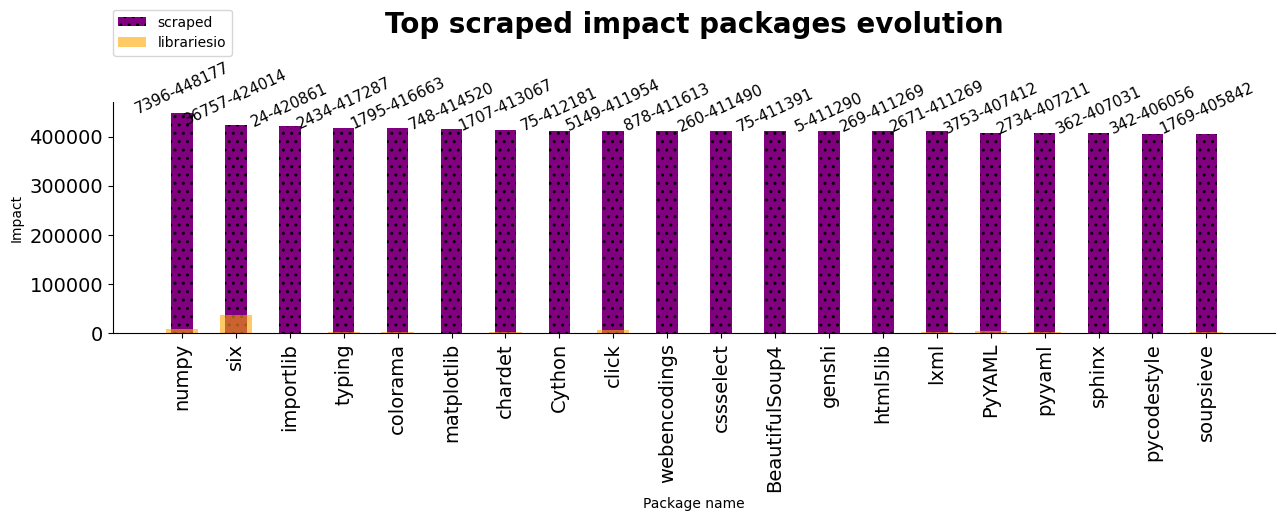

In [ ]:
# Top scraped impact packages evolution
# -------------------------------------

# order impact by librariesio value
impact_df.sort_values(by='scraped', ascending=False, inplace=True)
top_impact_scraped = dict(impact_df.head(20)['scraped'])

# Get the impact of the top scraped packages in the librariesio model
top_impact_librariesio = {}
for package in top_impact_scraped.keys():
    try:
        top_impact_librariesio[package] = librariesio_impact.results_dict[package]
    except KeyError:
        top_impact_librariesio[package] = 0

# Plot top impact packages evolution
plt.figure(figsize=(15, 3))
plt.bar(
    [x[0] for x in top_impact_scraped.items()],
    [x[1] for x in top_impact_scraped.items()],
    label='scraped',
    color='purple',
    width=0.4,
    hatch='..'
)

plt.bar(
    [x[0] for x in top_impact_librariesio.items()],
    [x[1] for x in top_impact_librariesio.items()],
    label='librariesio',
    color='orange',
    width=0.6,
    alpha=0.6,
)

for i, v, v2 in zip([x[0] for x in top_impact_librariesio.items()], [x[1] for x in top_impact_librariesio.items()], [x[1] for x in top_impact_scraped.items()]):
    plt.text(i, max(v,v2), f'{int(v)}-{int(v2)}', color='black', ha='center', rotation=25, fontsize=11)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=90)
plt.gca().tick_params(axis='y', labelsize=14)

plt.title('Top scraped impact packages evolution', fontsize=20, fontweight='bold', pad=50)

plt.xlabel('Package name')
plt.ylabel('Impact')
plt.legend(loc=(0,1.2))

# save plot
plt.savefig(f'{OUT_IMG_DIR}/top_scraped_impact_packages_evolution.png', bbox_inches='tight')
plt.show()

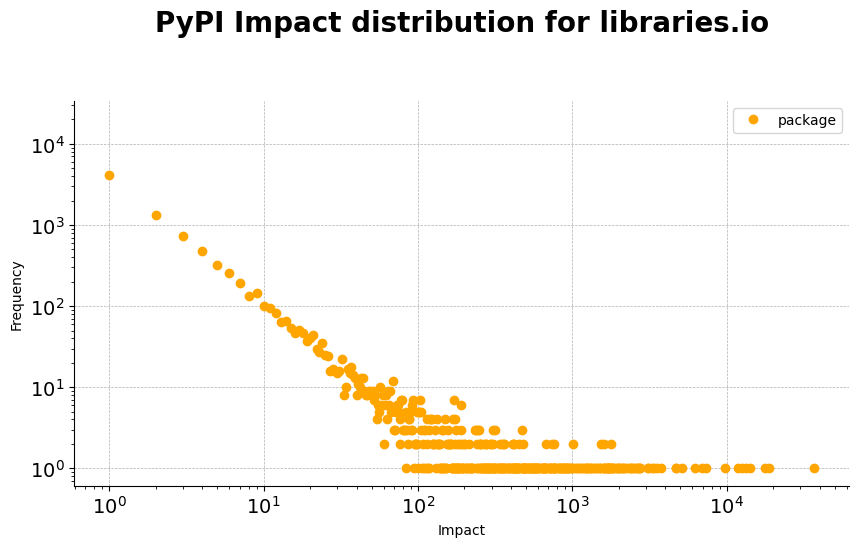

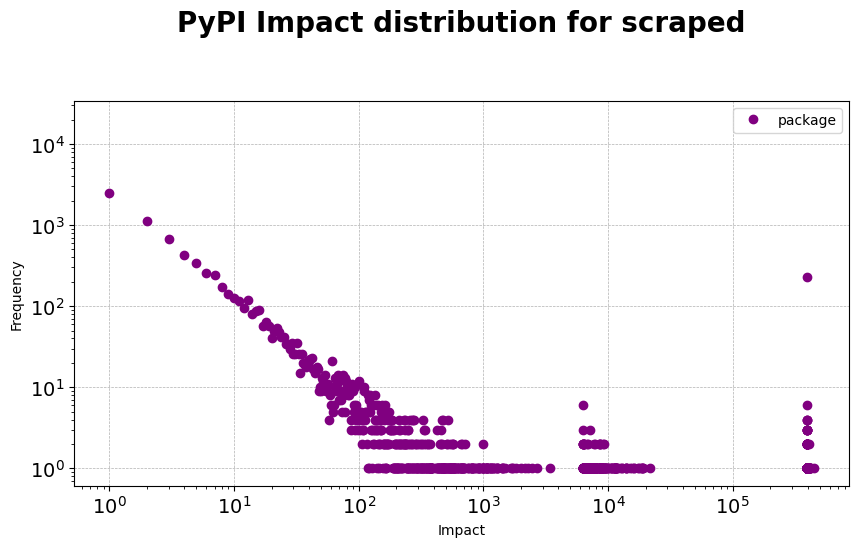

In [ ]:
# Impact distribution for libraries.io
# ------------------------------------

# Plot impact distribution
plt.figure(figsize=(10, 5))

impact = list(impact_df['librariesio'].dropna())
x, y = zip(*Counter(impact).items())

plt.plot(x, y, color='orange', marker='o', linestyle='None', label='package')

plt.title(f'{REPO_NAME} Impact distribution for libraries.io', fontsize=20, fontweight='bold', pad=50)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=0)
plt.gca().tick_params(axis='y', labelsize=14)
plt.xlabel('Impact')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xscale('log')
plt.yscale('log')




# save plot
plt.savefig(f'{OUT_IMG_DIR}/librariesio_impact_distribution.png', bbox_inches='tight')
plt.show()

# Impact distribution for scraped
# -------------------------------

# Plot impact distribution
plt.figure(figsize=(10, 5))

impact = list(impact_df['scraped'].dropna())
x, y = zip(*Counter(impact).items())

plt.plot(x, y, color='purple', marker='o', linestyle='None', label='package')
plt.title(f'{REPO_NAME} Impact distribution for scraped', fontsize=20, fontweight='bold', pad=50)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=0)
plt.gca().tick_params(axis='y', labelsize=14)
plt.xlabel('Impact')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xscale('log')
plt.yscale('log')

#Calcular el valor medio de la distribución

# save plot
plt.savefig(f'{OUT_IMG_DIR}/scraped_impact_distribution.png', bbox_inches='tight')
plt.show()






#### **5 - Surface**

In [ ]:
from olivia.packagemetrics import Surface

librariesio_surface = librariesio_model.get_metric(Surface)
scraped_surface = scraped_model.get_metric(Surface)

Computing Surface
     Processing node: 0K       
Computing Surface
     Processing node: 0K        


**Top surface**

######

In [ ]:
# Top 10 surface comparison
# -------------------------

top10_librariesio_surface = librariesio_surface.top(10)
top10_scraped_surface = scraped_surface.top(10)

# Top 10 surface comparison
top10_surface_df = pd.DataFrame(
    {
        'librariesio': top10_librariesio_surface,
        'scraped': top10_scraped_surface,
    }
)
top10_surface_df

librariesio                   scraped
0              (magnum, 145)         (tifascore, 1500)
1             (octavia, 144)            (adaseq, 1497)
2    (brasil.gov.tiles, 144)        (modelscope, 1496)
3             (vitrage, 144)     (geospatial-ml, 1421)
4           (cinderlib, 142)       (sdss-marvin, 1403)
5              (cinder, 141)  (NLP-Cryptography, 1390)
6  (ceilometer-powervm, 141)         (synthcity, 1384)
7                (nova, 141)            (marvin, 1383)
8              (karbor, 138)         (ai-python, 1381)
9         (cloudscript, 137)    (napari-chatgpt, 1378)

**Bottom surface**

###### 

In [ ]:
# Top 10 less surface
# ----------------

top10_librariesio_surface = librariesio_surface.bottom(10)
top10_scraped_surface = scraped_surface.bottom(10)

# Top 10 surface comparison
top10_surface_df = pd.DataFrame(
    {
        'librariesio': top10_librariesio_surface,
        'scraped': top10_scraped_surface,
    }
)
top10_surface_df

librariesio                 scraped
0             (tvdb-api, 1)              (w3lib, 1)
1           (stop-words, 1)            (grpclib, 1)
2               (cycler, 1)               (hkdf, 1)
3               (jpype1, 1)             (peewee, 1)
4             (alchimia, 1)             (grpcio, 1)
5           (python-pam, 1)         (frozenlist, 1)
6               (ipcalc, 1)  (changelogfromtags, 1)
7  (boto3-session-cache, 1)              (webob, 1)
8             (crosscap, 1)            (webtest, 1)
9          (unit_system, 1)             (testit, 1)

**Top surface increment**

######

In [ ]:
# Dataframe with the increments between the two models
librariesio_surface_df = pd.DataFrame(librariesio_surface.results_dict, index=['librariesio']).T
scraped_surface_df = pd.DataFrame(scraped_surface.results_dict, index=['scraped']).T

surface_df = pd.concat([librariesio_surface_df, scraped_surface_df], axis=1)
surface_df['increment'] = surface_df['scraped'] - surface_df['librariesio']
surface_df.sort_values(by='increment', ascending=False, inplace=True)
surface_df.head(10)


librariesio  scraped  increment
cityenergyanalyst          8.0   1348.0     1340.0
sdss-marvin               74.0   1403.0     1329.0
wharf                      8.0   1334.0     1326.0
pipelinex                  2.0   1324.0     1322.0
ballet                    11.0   1326.0     1315.0
featuretools              31.0   1320.0     1289.0
autonormalize             32.0   1320.0     1288.0
sagas                     21.0   1303.0     1282.0
bugbug                     2.0   1281.0     1279.0
darts                      2.0   1280.0     1278.0

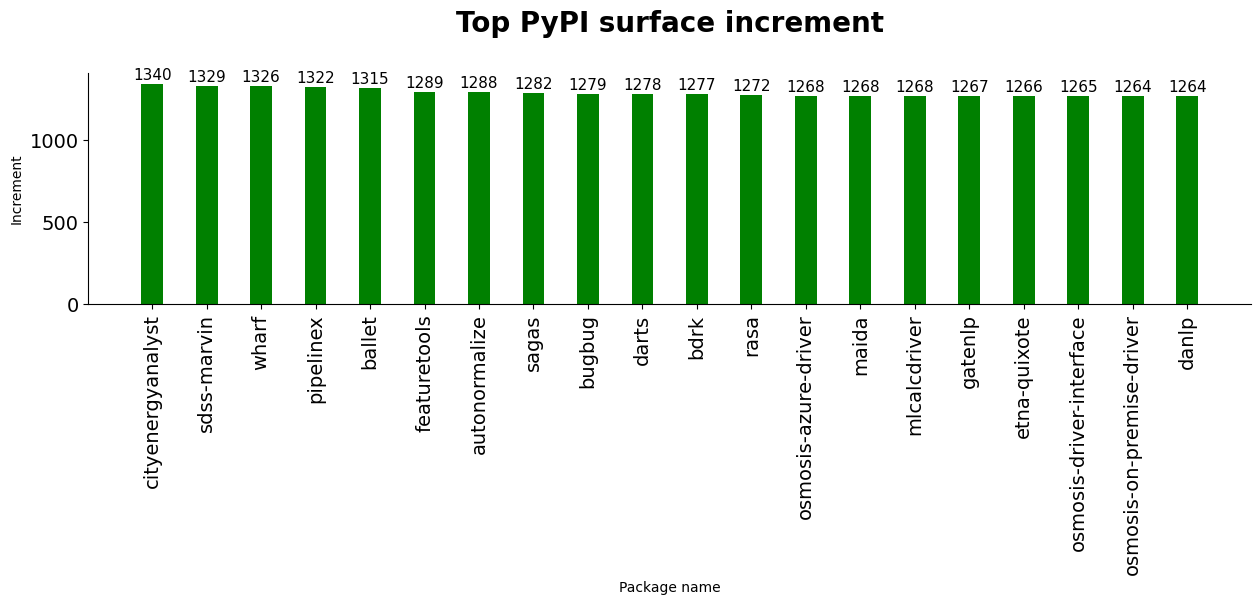

In [ ]:
# Plot surface increment
plt.figure(figsize=(15, 3))

increment = surface_df.head(20).astype(int)

plt.bar(
    increment.index,
    increment['increment'],
    color='green',
    width=0.4,
)

for i, v in zip(increment.index, increment['increment']):
    plt.text(i, v+30, f'{v}', color='black', ha='center', rotation=0, fontsize=11)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=90)
plt.gca().tick_params(axis='y', labelsize=14)
plt.title(f'Top {REPO_NAME} surface increment', fontsize=20, fontweight='bold', pad=30)

plt.xlabel('Package name')
plt.ylabel('Increment')

plt.savefig(f'{OUT_IMG_DIR}/top_surface_increment.png', bbox_inches='tight')
plt.show()


**Top surface decrease**

######

In [ ]:
# Decrease in surface
# -------------------

# Remove the rows with NaN values
surface_df = surface_df.dropna()
surface_df.tail(10)

librariesio  scraped  increment
pywwt                             66.0      1.0      -65.0
swifter                           66.0      1.0      -65.0
histomicsui                       72.0      5.0      -67.0
nova-lxd                          72.0      5.0      -67.0
airflow-aws-cost-explorer         75.0      2.0      -73.0
otree                             77.0      1.0      -76.0
rucio                             81.0      1.0      -80.0
starfish                          86.0      1.0      -85.0
kubeflow                          88.0      1.0      -87.0
localstack                        93.0      1.0      -92.0

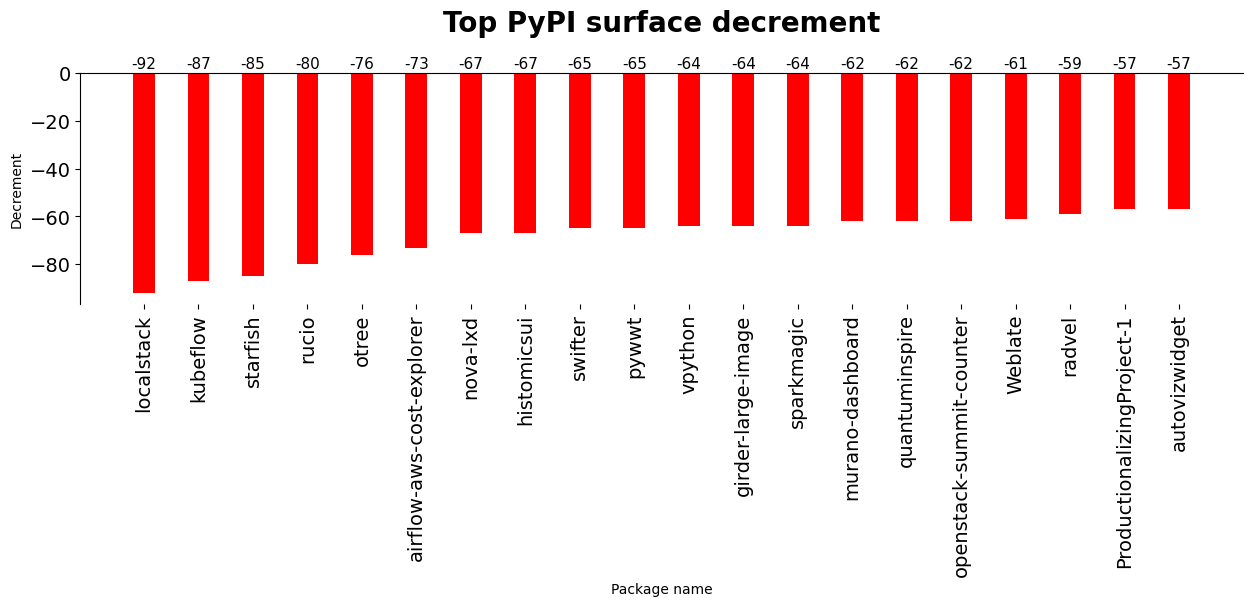

In [ ]:
# Plot surface decrement
plt.figure(figsize=(15, 3))

decrement = surface_df.tail(20).astype(int)

decrement.sort_values(by='increment', ascending=True, inplace=True)

plt.bar(
    decrement.index,
    decrement['increment'],
    color='red',
    width=0.4,
)

for i, v in zip(decrement.index, decrement['increment']):
    plt.text(i, 2, f'{v}', color='black', ha='center', rotation=0, fontsize=11)

# Adjusting plot borders
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=90)
plt.gca().tick_params(axis='y', labelsize=14)
plt.title(f'Top {REPO_NAME} surface decrement', fontsize=20, fontweight='bold', pad=30)

plt.xlabel('Package name')

plt.ylabel('Decrement')
plt.show()


**Evolution**

######

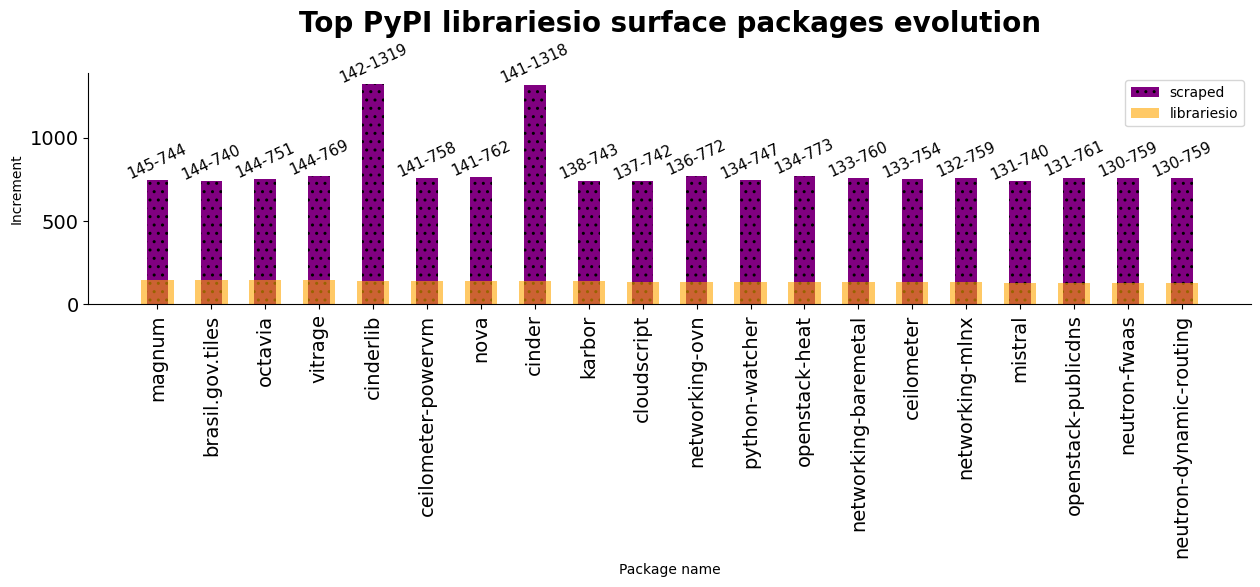

In [ ]:
# Evolution of the top librariesio surface packages
# ------------------------------------------------

# order surface by librariesio value
surface_df.sort_values(by='librariesio', ascending=False, inplace=True)
top_surface_librariesio = dict(surface_df.head(20)['librariesio'])

# Get the surface of the top librariesio packages for scraped model
top_surface_scraped = {}
for package in top_surface_librariesio.keys():
    try:
        top_surface_scraped[package] = scraped_surface.results_dict[package]
    except KeyError:
        print(f'Package {package} not found in scraped model')
        top_surface_scraped[package] = 0

# Plot the evolution of the top librariesio surface packages
plt.figure(figsize=(15, 3))

plt.bar(
    [x[0] for x in top_surface_scraped.items()],
    [x[1] for x in top_surface_scraped.items()],
    label='scraped',
    color='purple',
    width=0.4,
    hatch='..'
)

plt.bar(
    [x[0] for x in top_surface_librariesio.items()],
    [x[1] for x in top_surface_librariesio.items()],

    label='librariesio',
    color='orange',
    width=0.6,
    alpha=0.6,
)

for i, v, v2 in zip([x[0] for x in top_surface_librariesio.items()], [x[1] for x in top_surface_librariesio.items()], [x[1] for x in top_surface_scraped.items()]):
    plt.text(i, max(v,v2)+10, f'{int(v)}-{v2}', color='black', ha='center', rotation=25, fontsize=11)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=90)
plt.gca().tick_params(axis='y', labelsize=14)

plt.title(f'Top {REPO_NAME} librariesio surface packages evolution', fontsize=20, fontweight='bold', pad=30)

plt.xlabel('Package name')
plt.ylabel('Increment')
plt.legend()

plt.savefig(f'{OUT_IMG_DIR}/top_surface_evolution.png', bbox_inches='tight')
plt.show()


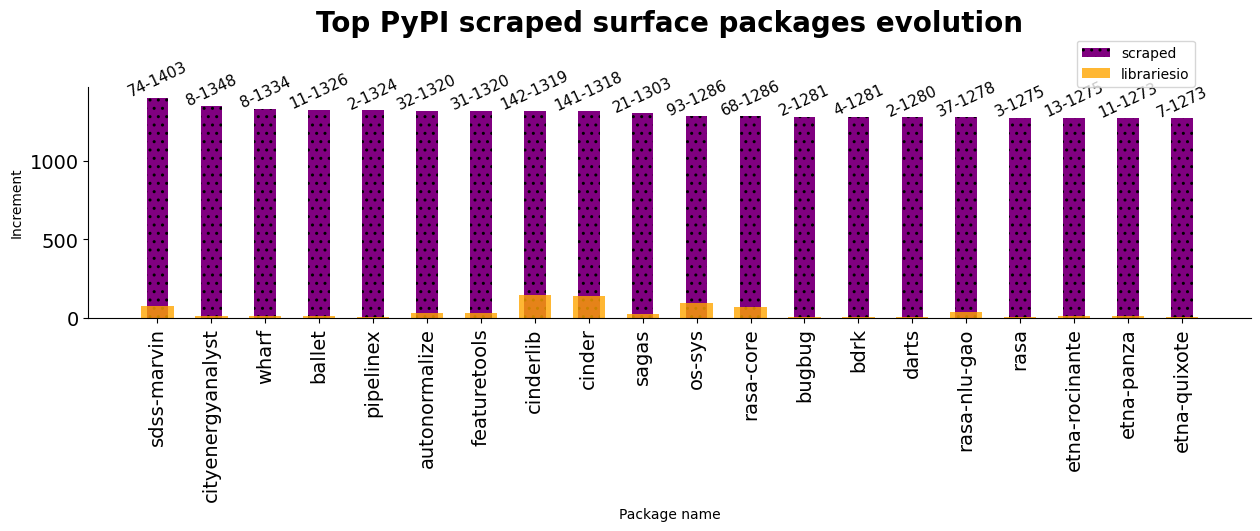

In [ ]:
# Evolution of the top scraped surface packages
# ---------------------------------------------

# order surface by scraped value
surface_df.sort_values(by='scraped', ascending=False, inplace=True)
top_surface_scraped = dict(surface_df.head(20)['scraped'])

# Get the surface of the top scraped packages for librariesio model
top_surface_librariesio = {}
for package in top_surface_scraped.keys():
    try:
        top_surface_librariesio[package] = librariesio_surface.results_dict[package]
    except KeyError:
        print(f'Package {package} not found in librariesio model')
        top_surface_librariesio[package] = 0

# Plot the evolution of the top scraped surface packages
plt.figure(figsize=(15, 3))

plt.bar(
    [x[0] for x in top_surface_scraped.items()],
    [x[1] for x in top_surface_scraped.items()],
    label='scraped',
    color='purple',
    width=0.4,
    hatch='..'
)

plt.bar(
    [x[0] for x in top_surface_librariesio.items()],
    [x[1] for x in top_surface_librariesio.items()],
    label='librariesio',
    color='orange',
    width=0.6,
    alpha=0.8,
)

for i, v, v2 in zip([x[0] for x in top_surface_scraped.items()], [x[1] for x in top_surface_scraped.items()], [x[1] for x in top_surface_librariesio.items()]):
    plt.text(i, max(v,v2)+10, f'{int(v2)}-{int(v)}', color='black', ha='center', rotation=25, fontsize=11)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14, rotation=90)
plt.gca().tick_params(axis='y', labelsize=14)
plt.title(f'Top {REPO_NAME} scraped surface packages evolution', fontsize=20, fontweight='bold', pad=40)

plt.xlabel('Package name')
plt.ylabel('Increment')
plt.legend(loc=(0.85,1))

plt.savefig(f'{OUT_IMG_DIR}/top_surface_evolution.png', bbox_inches='tight')
plt.show()


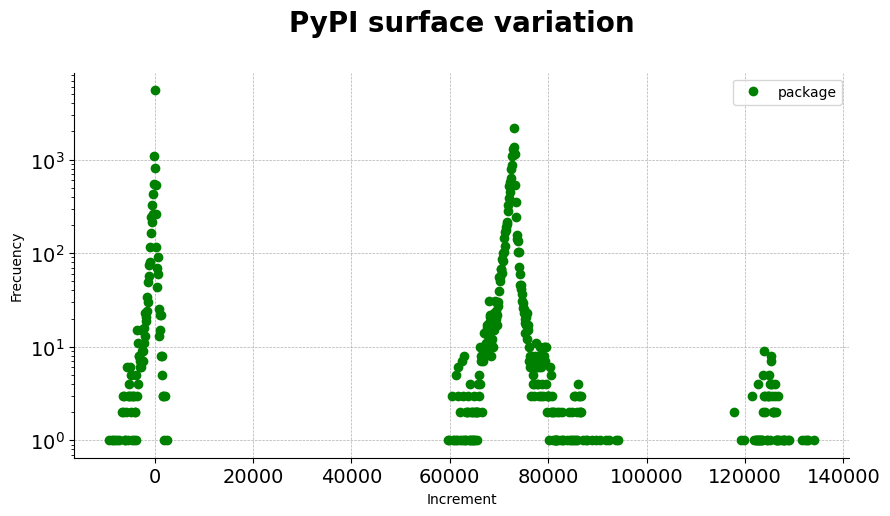

In [ ]:
# Surface variation
# ---------------

surface_increase = list(surface_df['increment'].dropna())
surface_increase.sort(reverse=True)

# Plot impact increase
plt.figure(figsize=(10, 5))

surface_increase = [int(x / 1) * 100 for x in surface_increase]
x, y = zip(*Counter(surface_increase).items())
plt.plot(x, y, color='green', marker='o', linestyle='None', label='package')
plt.title(f'{REPO_NAME} surface variation', fontsize=20, fontweight='bold', pad=30)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14)
plt.gca().tick_params(axis='y', labelsize=14)
plt.xlabel('Increment')
plt.ylabel('Frecuency')
plt.legend()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xscale('linear')
plt.yscale('log')


plt.savefig(f'{OUT_IMG_DIR}/surface_variation.png', bbox_inches='tight')
plt.show()

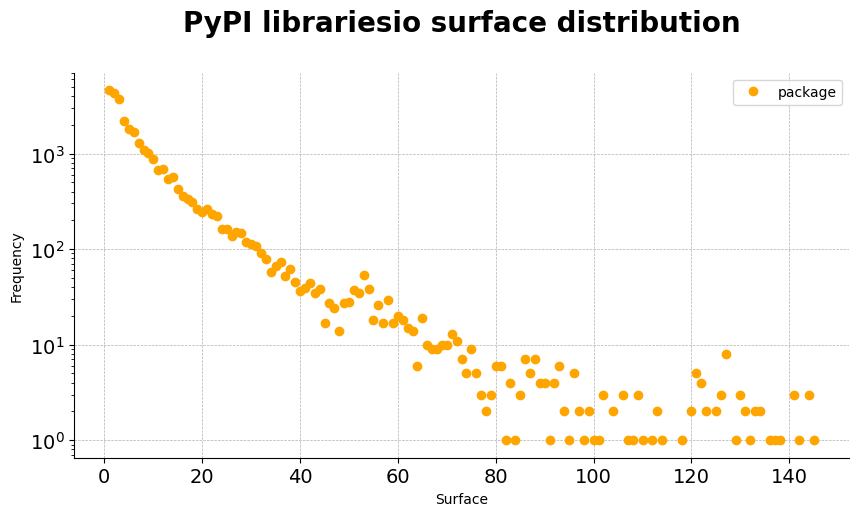

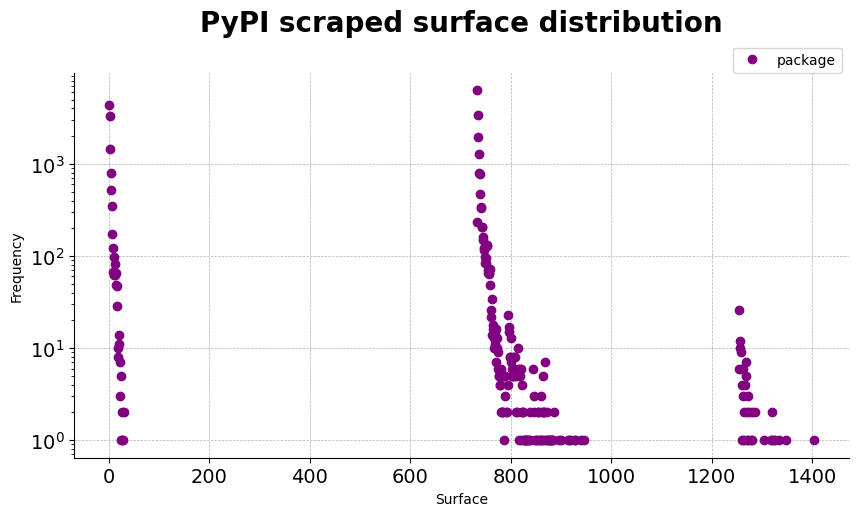

In [ ]:
# Surface distribution for libraries.io
# -------------------------------------

# Plot Surface distribution
import statistics


plt.figure(figsize=(10, 5))
surface = list(surface_df['librariesio'].dropna())
x, y = zip(*Counter(surface).items())
plt.plot(x, y, color='orange', marker='o', linestyle='None', label='package')
plt.title(f'{REPO_NAME} librariesio surface distribution', fontsize=20, fontweight='bold', pad=30)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14)
plt.gca().tick_params(axis='y', labelsize=14)
plt.xlabel('Surface')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
# plt.xscale('log')
plt.yscale('log')

plt.savefig(f'{OUT_IMG_DIR}/librariesio_surface_distribution.png', bbox_inches='tight')
plt.show()

# Surface distribution for scraped
# --------------------------------

# Plot Surface distribution
plt.figure(figsize=(10, 5))
surface = list(surface_df['scraped'].dropna())
x, y = zip(*Counter(surface).items())
plt.plot(x, y, color='purple', marker='o', linestyle='None', label='package')
plt.title(f'{REPO_NAME} scraped surface distribution', fontsize=20, fontweight='bold', pad=30)

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14)
plt.gca().tick_params(axis='y', labelsize=14)
plt.xlabel('Surface')
plt.ylabel('Frequency')
plt.legend(loc=(0.85,1))
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
# plt.xscale('log')
plt.yscale('log')


plt.savefig(f'{OUT_IMG_DIR}/scraped_surface_distribution.png', bbox_inches='tight')
plt.show()

#### Dependencies

In [ ]:
from olivia.packagemetrics import DependenciesCount

librariesio_dependencies = librariesio_model.get_metric(DependenciesCount)
scraped_dependencies = scraped_model.get_metric(DependenciesCount)

Computing Dependencies Count
Computing Dependencies Count


**Top dependencies**

###### 

In [ ]:
# Top 10 dependencies count
# ----------------

top10_librariesio_dependencies_count = librariesio_dependencies.top(10)
top10_scraped_dependencies_count = scraped_dependencies.top(10)

# Top 10 dependencies count comparison
top10_dependencies_count_df = pd.DataFrame(
    {
        'librariesio': top10_librariesio_dependencies_count,
        'scraped': top10_scraped_dependencies_count,
    }
)
top10_dependencies_count_df

librariesio                       scraped
0  (cloudscript, 120)              (ai-python, 358)
1    (c7n-azure, 105)       (NLP-Cryptography, 352)
2   (TEStribute, 102)                (ivystar, 265)
3      (nucypher, 96)  (animal-classification, 230)
4     (azure-cli, 72)               (bitfount, 218)
5        (cateye, 72)            (luisito1996, 211)
6   (mycloud-cli, 71)           (luisito19963, 210)
7     (cloudview, 69)               (luis1996, 208)
8  (ML-Navigator, 68)             (omdenalore, 206)
9          (nova, 68)           (trialtracker, 200)

**Bottom dependencies**

###### 

In [ ]:
# Top 10 less dependencies count
# ----------------

top10_librariesio_dependencies_count = librariesio_dependencies.bottom(10)
top10_scraped_dependencies_count = librariesio_dependencies.bottom(10)

# Top 10 dependencies count comparison
top10_dependencies_count_df = pd.DataFrame(
    {
        'librariesio': top10_librariesio_dependencies_count,
        'scraped': top10_scraped_dependencies_count,
    }
)
top10_dependencies_count_df

librariesio                  scraped
0    (www-authenticate, 0)    (www-authenticate, 0)
1          (tensorflow, 0)          (tensorflow, 0)
2        (biopy-isatab, 0)        (biopy-isatab, 0)
3          (ftw.slider, 0)          (ftw.slider, 0)
4          (z3c.schema, 0)          (z3c.schema, 0)
5       (ftw.zipexport, 0)       (ftw.zipexport, 0)
6       (ftw.iframefix, 0)       (ftw.iframefix, 0)
7      (plone.app.blob, 0)      (plone.app.blob, 0)
8  (django-ace-overlay, 0)  (django-ace-overlay, 0)
9          (errand-boy, 0)          (errand-boy, 0)

**Top dependencies increment**

###### 

In [ ]:
# Dataframe with the differences between the two models
librariesio_dependencies_count_df = pd.DataFrame(librariesio_dependencies.results_dict, index=['librariesio']).T
scraped_dependencies_count_df = pd.DataFrame(scraped_dependencies.results_dict, index=['scraped']).T

dependencies_count_df = pd.concat([librariesio_dependencies_count_df, scraped_dependencies_count_df], axis=1)
dependencies_count_df['increment'] = dependencies_count_df['scraped'] - dependencies_count_df['librariesio']
dependencies_count_df.sort_values(by='increment', ascending=False, inplace=True)
dependencies_count_df.head(10)

librariesio  scraped  increment
apache-airflow          41.0    185.0      144.0
sentry                  23.0    115.0       92.0
raiden                   0.0     88.0       88.0
crossbar                10.0     89.0       79.0
pyswarms                 2.0     78.0       76.0
rasa                     1.0     68.0       67.0
XTCryptoSignals         20.0     84.0       64.0
seleniumbase            17.0     79.0       62.0
c7n-mailer              11.0     69.0       58.0
panel                    5.0     63.0       58.0

**Top dependencies decrement**

###### 

In [ ]:
# Decrease in dependencies count
# -------------------

# Remove the rows with NaN values
dependencies_count_df = dependencies_count_df.dropna()
dependencies_count_df.tail(10)

librariesio  scraped  increment
koku-nise                   46.0      8.0      -38.0
the-whole-caboodle          43.0      5.0      -38.0
zbuilder                    60.0     21.0      -39.0
horizon                     61.0     21.0      -40.0
edx-enterprise-data         60.0     17.0      -43.0
c7n-azure                  105.0     47.0      -58.0
otree                       58.0      0.0      -58.0
rucio                       60.0      0.0      -60.0
cateye                      72.0      2.0      -70.0
cloudscript                120.0     36.0      -84.0

**Evolution**

###### 

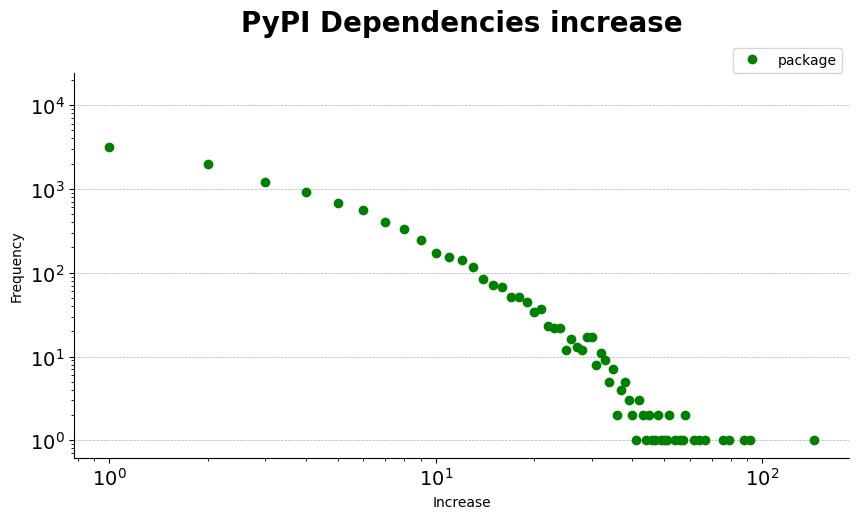

In [ ]:
# Dependencies variation
# --------------------------------

dependencies_increase = list(dependencies_count_df['increment'].dropna())
dependencies_increase.sort(reverse=True)

# Plot impact increase
plt.figure(figsize=(10, 5))

x, y = zip(*Counter(dependencies_increase).items())

plt.plot(x, y, color='green', marker='o', linestyle='None', label='package')

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14)
plt.gca().tick_params(axis='y', labelsize=14)

plt.title(f'{REPO_NAME} Dependencies increase', fontsize=20, fontweight='bold', pad=30)
plt.ylabel('Frequency')
plt.xlabel('Increase')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc=(0.85,1))

plt.grid(axis='y', linestyle='--', linewidth=0.5)

plt.savefig(f'{OUT_IMG_DIR}/dependencies_increase.png', bbox_inches='tight')
plt.show()






#### Dependents

In [ ]:
from olivia.packagemetrics import DependentsCount

librariesio_dependents = librariesio_model.get_metric(DependentsCount)
scraped_dependents = scraped_model.get_metric(DependentsCount)

Computing Dependents Count
Computing Dependents Count


In [ ]:
# Top 10 dependents count
# ----------------

top10_librariesio_dependents_count = librariesio_dependents.top(10)
top10_scraped_dependents_count = scraped_dependents.top(10)

# Top 10 dependents count comparison
top10_dependents_count_df = pd.DataFrame(
    {
        'librariesio': top10_librariesio_dependents_count,
        'scraped': top10_scraped_dependents_count,
    }
)
top10_dependents_count_df

librariesio              scraped
0        (requests, 10156)       (numpy, 39295)
1              (six, 4451)    (requests, 37816)
2            (numpy, 3773)      (pandas, 25584)
3            (click, 2403)      (pytest, 24354)
4       (setuptools, 1921)  (matplotlib, 16979)
5  (python-dateutil, 1735)       (scipy, 15892)
6           (pyyaml, 1656)      (python, 15668)
7           (PyYAML, 1390)        (odoo, 13794)
8             (lxml, 1215)       (click, 12657)
9           (pandas, 1129)        (tqdm, 10382)

In [ ]:
# Top 10 less dependents count
# ----------------------------

top10_librariesio_dependents_count = librariesio_dependents.bottom(10)
top10_scraped_dependents_count = scraped_dependents.bottom(10)

# Top 10 dependents count comparison
top10_dependents_count_df = pd.DataFrame(
    {
        'librariesio': top10_librariesio_dependents_count,
        'scraped': top10_scraped_dependents_count,
    }
)

top10_dependents_count_df

librariesio                                       scraped
0                 (ddlworker, 0)                  (openimis-be-calculation, 0)
1               (enturclient, 0)  (openimis-be-calcrule-capitation-payment, 0)
2                (graph-nets, 0)                   (openImagePreprocessing, 0)
3                 (bulb-core, 0)                           (openhub-django, 0)
4                   (edp-cli, 0)                (openhab-pythonrule-engine, 0)
5               (mozdef-util, 0)                                  (opengov, 0)
6              (gofer-grader, 0)                             (OpenGeode-IO, 0)
7       (django-exo-mentions, 0)                                 (opengame, 0)
8                (sanic-boom, 0)                        (openflexure-stage, 0)
9  (django-pyodbc-azure-2019, 0)                       (matos-aws-provider, 0)

In [ ]:
# Dataframe with the differences between the two models
librariesio_dependents_count_df = pd.DataFrame(librariesio_dependents.results_dict, index=['librariesio']).T
scraped_dependents_count_df = pd.DataFrame(scraped_dependents.results_dict, index=['scraped']).T

dependents_count_df = pd.concat([librariesio_dependents_count_df, scraped_dependents_count_df], axis=1)
dependents_count_df['difference'] = dependents_count_df['scraped'] - dependents_count_df['librariesio']
dependents_count_df.sort_values(by='difference', ascending=False, inplace=True)
dependents_count_df.head(10)

librariesio  scraped  difference
numpy            3773.0  39295.0     35522.0
requests        10156.0  37816.0     27660.0
pandas           1129.0  25584.0     24455.0
pytest            900.0  24354.0     23454.0
matplotlib        658.0  16979.0     16321.0
scipy             738.0  15892.0     15154.0
click            2403.0  12657.0     10254.0
tqdm              795.0  10382.0      9587.0
sphinx            219.0   8664.0      8445.0
flake8            165.0   8004.0      7839.0

In [ ]:
# Decrease in dependents count
# -------------------

# Remove the rows with NaN values
dependents_count_df = dependents_count_df.dropna()
dependents_count_df.tail(10)

librariesio  scraped  difference
public                          158.0     11.0      -147.0
aws-cdk.core                    153.0      0.0      -153.0
oslo.utils                      153.0      0.0      -153.0
Adafruit-Blinka                 154.0      0.0      -154.0
python-dotenv                   176.0      0.0      -176.0
requests-toolbelt               178.0      0.0      -178.0
websocket-client                217.0      0.0      -217.0
scikit-learn                    217.0      0.0      -217.0
google-api-python-client        220.0      0.0      -220.0
python-dateutil                1735.0      0.0     -1735.0

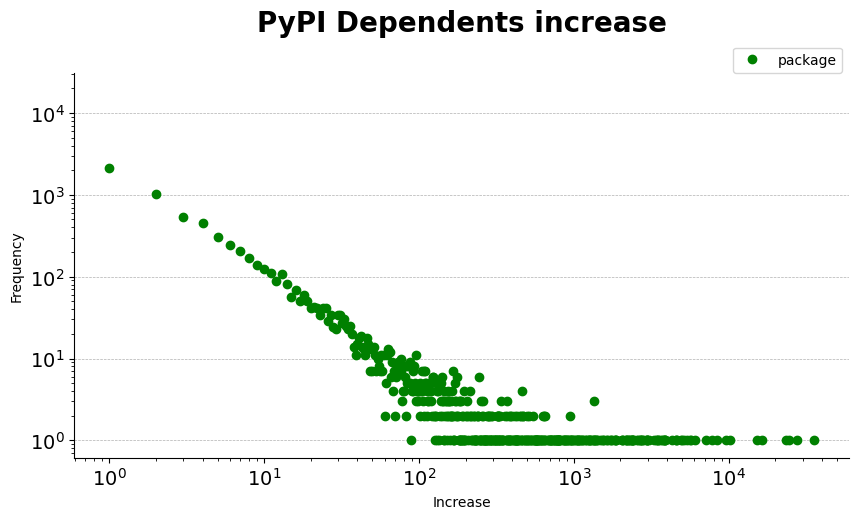

In [ ]:
# Dependents variation
# --------------------------------

dependents_increase = list(dependents_count_df['difference'].dropna())
dependents_increase.sort(reverse=True)

# Plot impact increase
plt.figure(figsize=(10, 5))

x, y = zip(*Counter(dependents_increase).items())

plt.plot(x, y, color='green', marker='o', linestyle='None', label='package')

# Adjusting plot borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjusting tick labels font size
plt.gca().tick_params(axis='x', labelsize=14)
plt.gca().tick_params(axis='y', labelsize=14)

plt.title(f'{REPO_NAME} Dependents increase', fontsize=20, fontweight='bold', pad=30)
plt.ylabel('Frequency')
plt.xlabel('Increase')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc=(0.85,1))

plt.grid(axis='y', linestyle='--', linewidth=0.5)

plt.savefig(f'{OUT_IMG_DIR}/dependents_increase.png', bbox_inches='tight')
plt.show()
